In [37]:
base_dirs = [
    'logs/bpic2011',
    'logs/bpic2013',
    'logs/CoSeLoG',
    'logs/Hospital_billings',
    'logs/sepsis',
    'logs/traffic_fines',
]

## Runtime Analysis

Total time is: 4.0 days, 23.0 hours, 59.0 minutes, and 26.598676919937134 seconds.


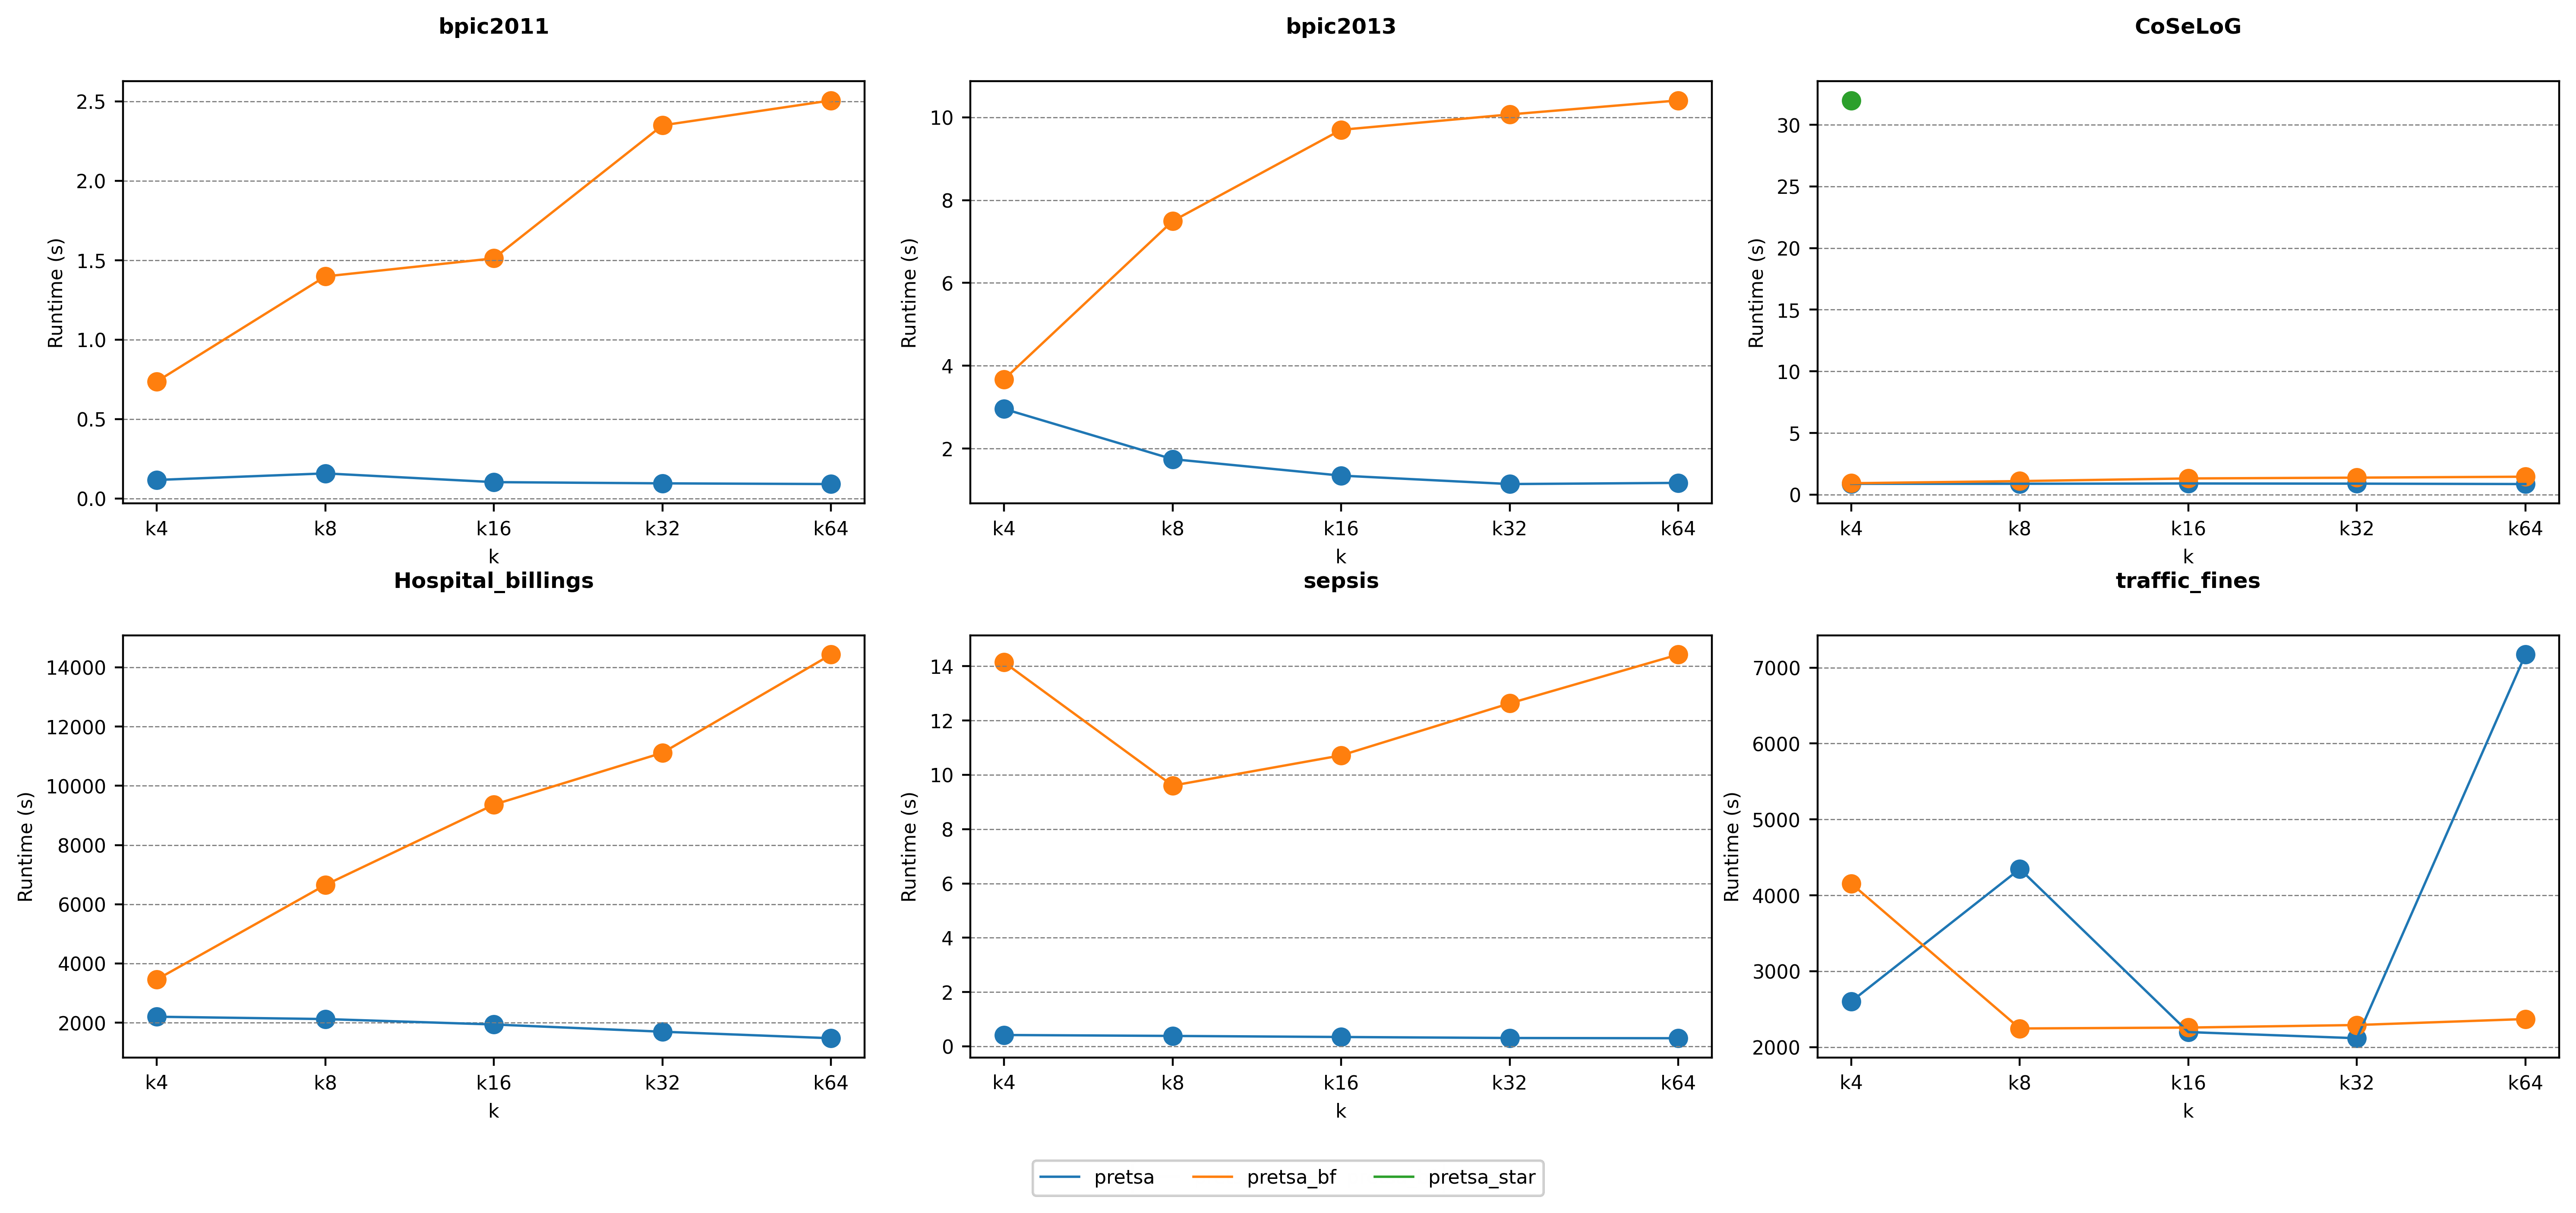

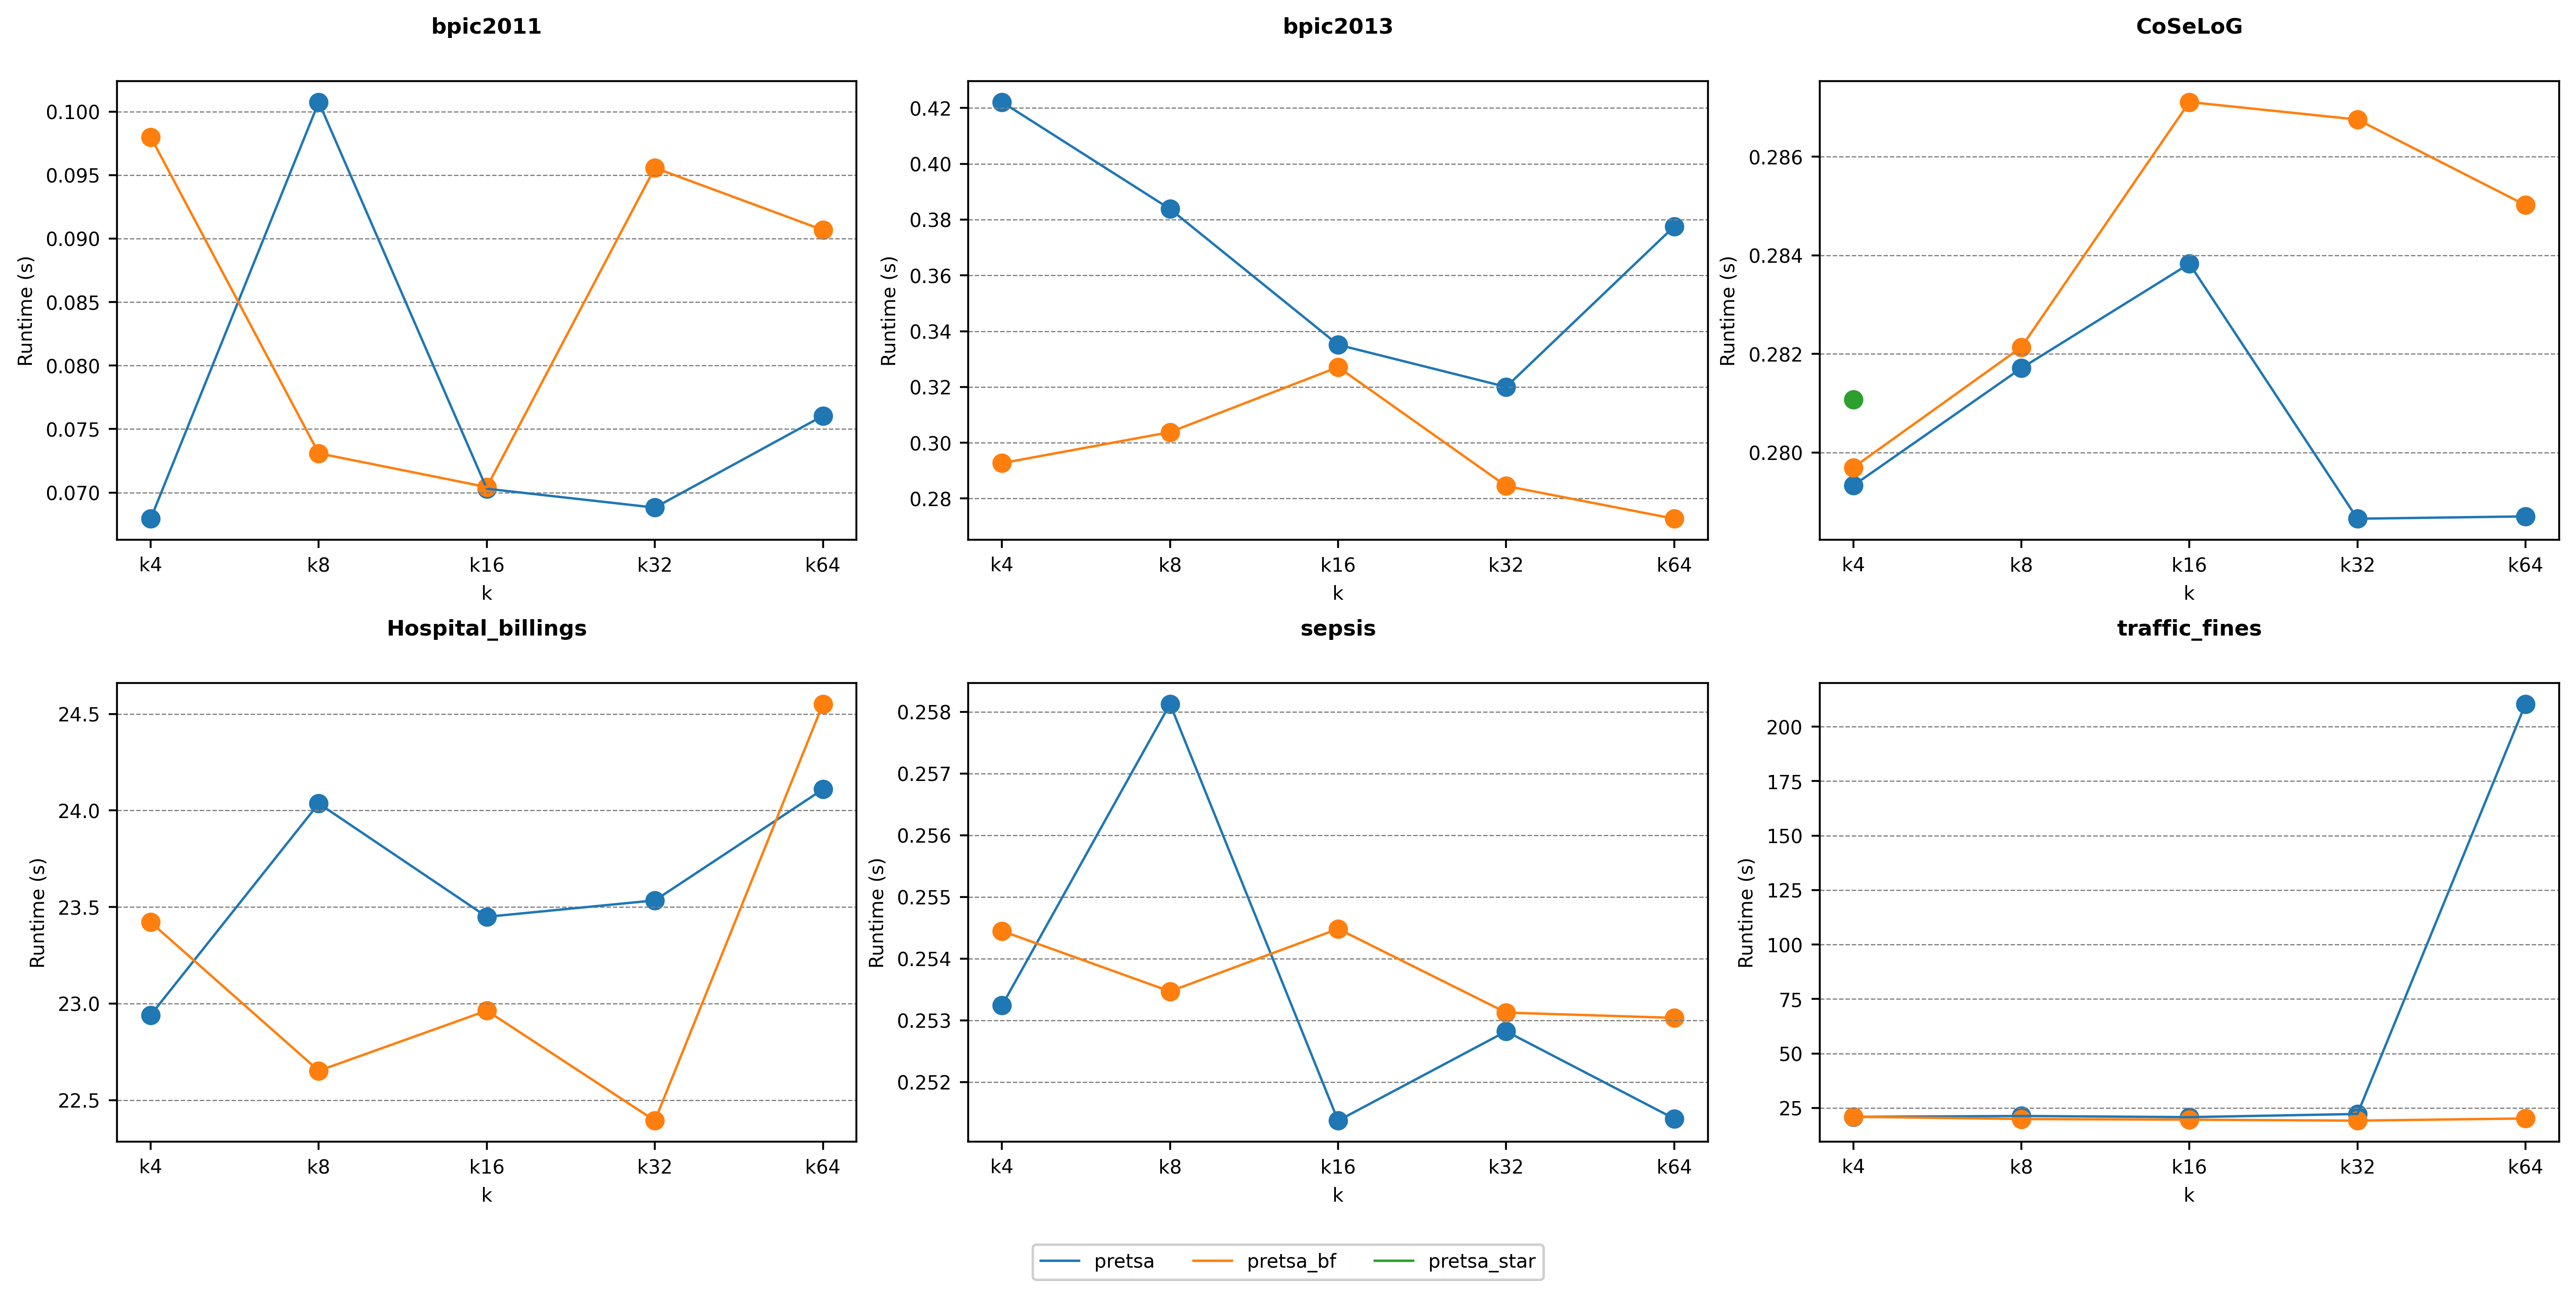

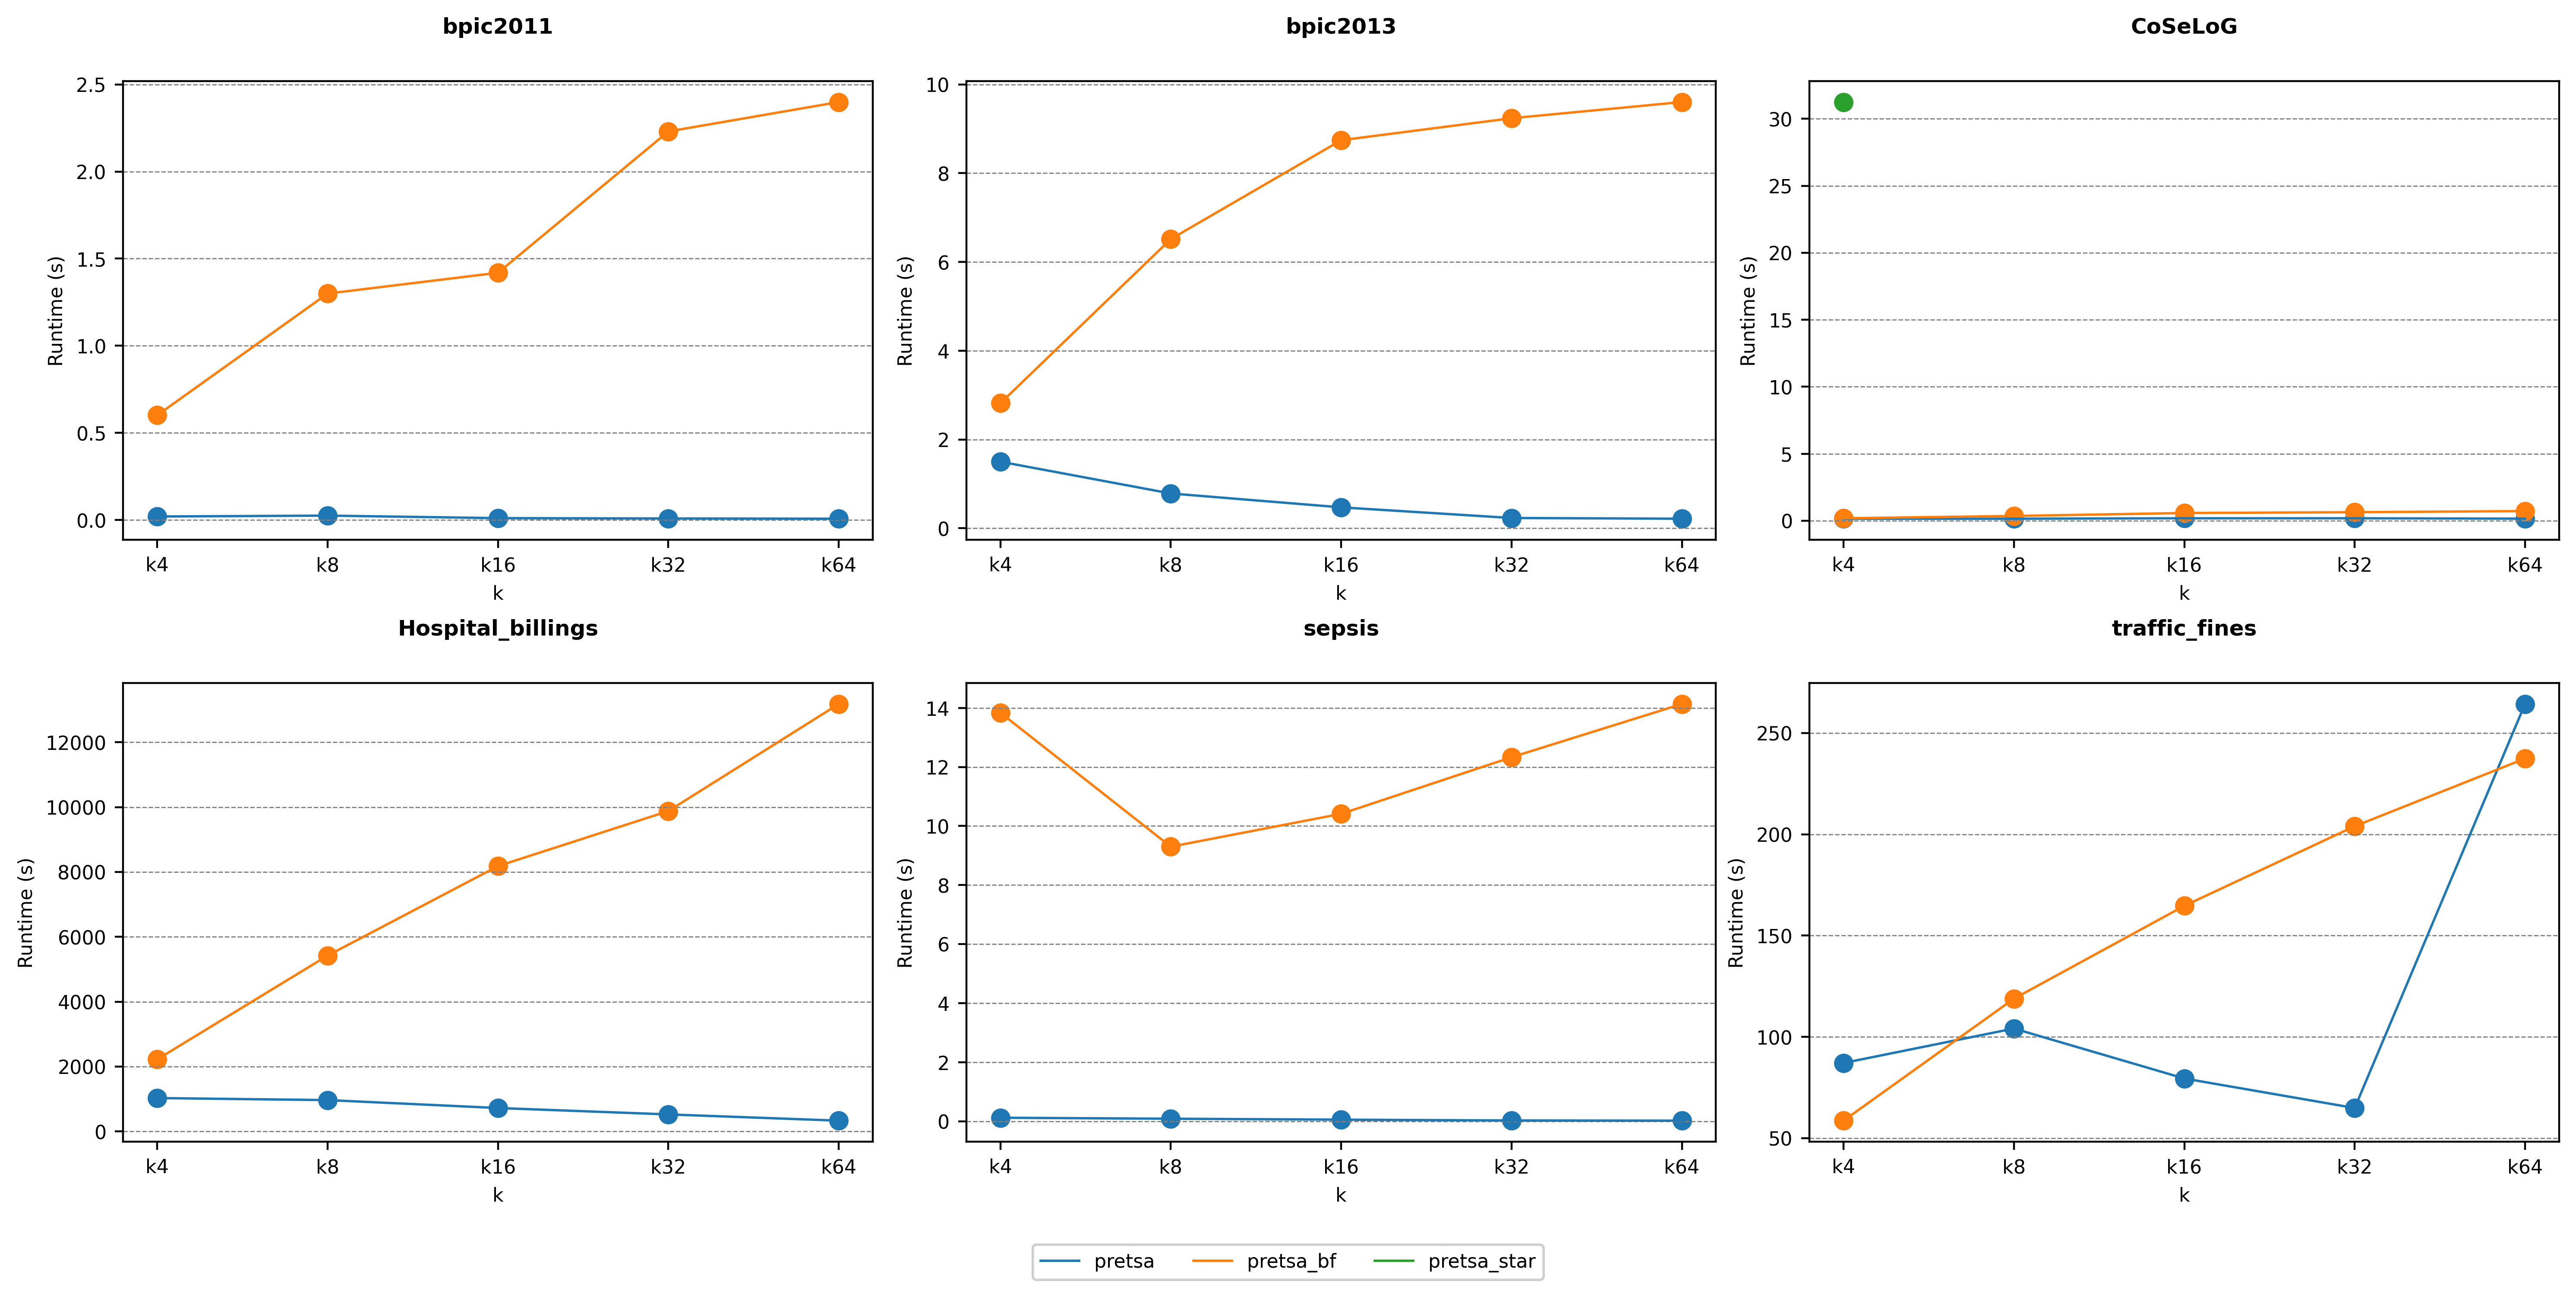

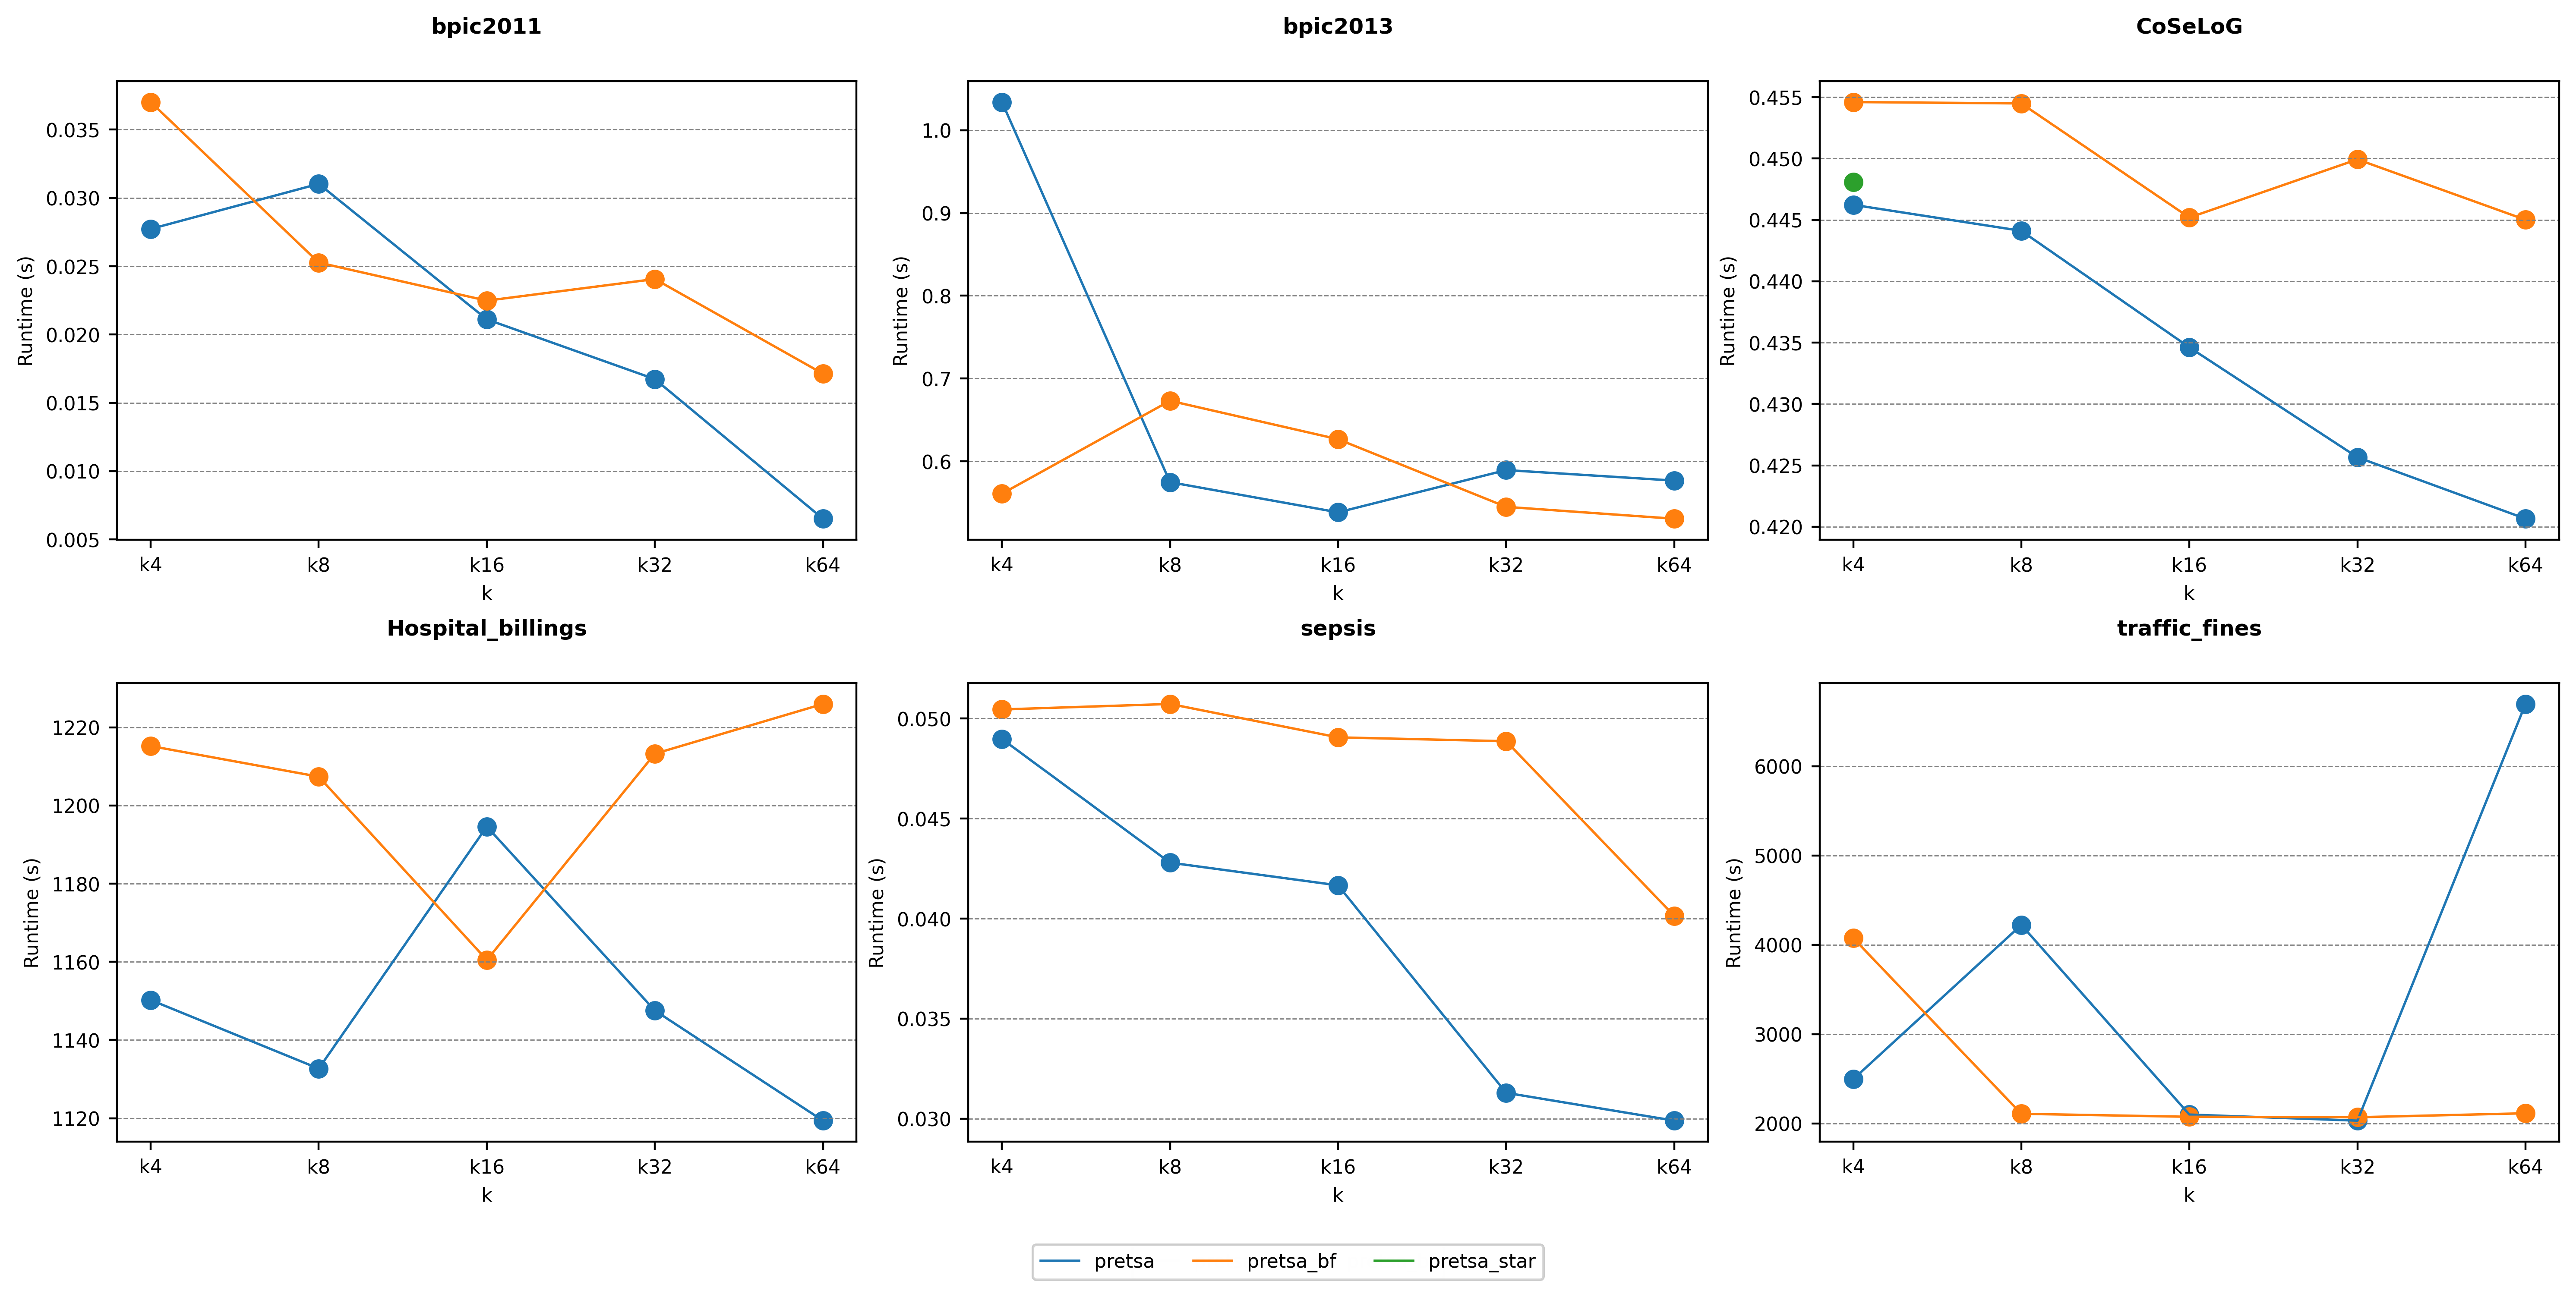

In [51]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.colors as mcolors


def load_pickles(root_dir):
    all_pickles = defaultdict(lambda: defaultdict(list))
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.pickle'):
                dataset_name = os.path.basename(root_dir)
                if 'heuristic_pretsa' in file:
                    algorithm = 'pretsa_bf'
                elif 'pretsa_star' in file:
                    algorithm = 'pretsa_star'
                elif 'pretsa' in file:
                    algorithm = 'pretsa'
                else:
                    continue
                all_pickles[dataset_name][algorithm].append(os.path.join(root, file))
    return all_pickles


def parse_pickles(pickle_files, runtime_type):
    data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    for dataset_name, algorithms in pickle_files.items():
        for algorithm, files in algorithms.items():
            for pickle_file in files:
                with open(pickle_file, 'rb') as f:
                    content = pickle.load(f)
                    parts = pickle_file.split('/')
                    setting = parts[-1].split('_')
                    k_value = setting[3]
                    if runtime_type == 'overall':
                        runtime = sum(content['runtimes'].values())
                    else:
                        runtime = content['runtimes'].get(runtime_type, 0)
                    data[dataset_name][algorithm][k_value].append(runtime)
    return data


def calculate_averages(data):
    averages = defaultdict(lambda: defaultdict(dict))
    for dataset_name, algorithms in data.items():
        for algorithm, k_values in algorithms.items():
            for k, runtimes in k_values.items():
                averages[dataset_name][algorithm][k] = np.mean(runtimes)
    return averages

def convert_seconds(total_seconds):
    minutes, seconds = divmod(total_seconds, 60)
    hours, minutes = divmod(minutes, 60)
    days, hours = divmod(hours, 24)
    
    return days, hours, minutes, seconds

def calculate_total_runtime(data):
    total_sum = 0
    for dataset_name, algorithms in data.items():
        for algorithm, k_values in algorithms.items():
            for k, runtimes in k_values.items():
                total_sum += np.sum(runtimes)
    

    days, hours, minutes, seconds = convert_seconds(total_sum)

    print(f"Total time is: {days} days, {hours} hours, {minutes} minutes, and {seconds} seconds.")
    # convert seconds to minutes, hours, days
    

    return None


def plot_averages(averages, runtime_type, is_overall):
    colors = list(mcolors.TABLEAU_COLORS)
    datasets = list(averages.keys())
    num_datasets = len(datasets)
    
    if is_overall:
        # fig, axes = plt.subplots(nrows=num_datasets, ncols=1, figsize=(13, 2 * num_datasets), dpi=100)
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7), dpi=400)
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7), dpi=400)
        axes = axes.flatten()

    if num_datasets == 1:
        axes = [axes]
    legend_handles = {}

    for ax_index, dataset_name in enumerate(datasets):
        ax = axes[ax_index] if not is_overall else axes[ax_index]
        color_index = 0


        all_runtimes = [runtime for k_averages in averages[dataset_name].values() for runtime in k_averages.values()]


        min_runtime = min(all_runtimes)
        max_runtime = max(all_runtimes)

        # for spine in ax.spines.values():
        #     spine.set_color('grey')
        #     spine.set_linewidth(0.5)
        
        # Set y-axis limits with padding
        # ax.set_ylim(min_runtime - min_runtime * 0.1, max_runtime + max_runtime * 0.1)
        # ax.tick_params(axis='both', which='both', color='grey', labelcolor='grey')

        for algorithm_index, (algorithm, k_averages) in enumerate(averages[dataset_name].items()):
            k_values = sorted(k_averages.keys(), key=lambda x: int(x[1:]))
            avg_runtimes = [k_averages[k] for k in k_values]


            line_color = colors[color_index % len(colors)]
            color_index += 1

            scatter = ax.scatter(k_values, avg_runtimes, s=50, color=line_color, label=algorithm)
            line, = ax.plot(k_values, avg_runtimes, color=line_color, linewidth=1)

            if algorithm in ['pretsa', 'pretsa_bf', 'pretsa_star']:
                legend_handles[algorithm] = line

            # for i, txt in enumerate(avg_runtimes):
            #     xytext_offset = (0, 5) if algorithm_index % 2 == 0 else (0, -15)
            #     ax.annotate(f'{txt:.2f}', (k_values[i], avg_runtimes[i]),
            #                 textcoords="offset points", xytext=xytext_offset, ha='center',
            #                 fontsize=7, fontweight='bold', color=line_color)


        ax.set_title(f'{dataset_name}', fontsize=9, fontweight='bold', pad=20)
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='grey') 

        ax.set_xlabel('k', fontsize=8)
        ax.set_ylabel('Runtime (s)', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)

    # if is_overall:
    #     fig.legend(legend_handles.values(), legend_handles.keys(), loc='upper right', fontsize=8)
    # else:
        # fig.text(0.95, 0.05, f'Runtime Analysis - {runtime_type}', fontsize=14, fontweight='bold', color='grey', ha='right', va='bottom')

        fig.legend(legend_handles.values(), legend_handles.keys(), loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=8)

    plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
    # plt.suptitle(f'Runtime Analysis - {runtime_type}', fontsize=14, fontweight='bold', color='grey')

    plt.subplots_adjust(top=0.88 if is_overall else 0.95)
    plt.show()


all_pickle_files = {}
for base_dir in base_dirs:
    all_pickle_files.update(load_pickles(base_dir))


runtime_types = ['overall', 'exp_time', 'pretsa_time', 'private_time']


parsed_data = parse_pickles(all_pickle_files, 'overall')

calculate_total_runtime(parsed_data)

averages = calculate_averages(parsed_data)
plot_averages(averages, 'overall', is_overall=True)


for runtime_type in runtime_types[1:]:
    parsed_data = parse_pickles(all_pickle_files, runtime_type)
    averages = calculate_averages(parsed_data)
    plot_averages(averages, runtime_type, is_overall=False)


# Runtime Corealtion Analysis

In [38]:
import pandas as pd
import pickle


file_path_event_log = 'event_log_characteristics.pickle'
file_path_unified_insights = 'unified_insights.pickle'


with open(file_path_event_log, 'rb') as file:
    event_log_characteristics = pickle.load(file)

with open(file_path_unified_insights, 'rb') as file:
    unified_insights = pickle.load(file)



In [39]:
import numpy as np


unified_insights_df = pd.DataFrame(unified_insights)


for characteristic in event_log_characteristics.keys():
    for key in event_log_characteristics[characteristic]:
        unified_insights_df.loc[unified_insights_df['eventlog'] == characteristic, key] = event_log_characteristics[characteristic][key]


unified_insights_df['runtimes'] = unified_insights_df.apply(
    lambda row: {'exp_time': row['runtimes']['exp_time'], 
                 'private_time': row['runtimes']['private_time'], 
                 'pretsa_bf_time' if row['algorithm'] == 'pretsa_bf' else 'pretsa_time': row['runtimes']['pretsa_time']}, 
    axis=1
)


runtimes_df = unified_insights_df['runtimes'].apply(pd.Series)
unified_insights_df = pd.concat([unified_insights_df.drop(['runtimes'], axis=1), runtimes_df], axis=1)


unified_insights_df['k_value'] = unified_insights_df['k_value'].apply(lambda x: int(x[1:])) if 'k_value' in unified_insights_df else unified_insights_df['k'].apply(lambda x: int(x))
unified_insights_df['t_value'] = unified_insights_df['t_value'].apply(lambda x: int(x[1:])) if 't_value' in unified_insights_df else unified_insights_df['t'].apply(lambda x: int(x))



unified_insights_df.head()



eventlog algorithm  k_value  t_value  number_of_cases  inflictedChanges  \
0  bpic2011    pretsa        8        1               71             100.0   
1  bpic2011    pretsa       64        1              184             438.0   
2  bpic2011    pretsa       64        4              184             438.0   
3  bpic2011    pretsa        4        3               35              46.0   
4  bpic2011    pretsa       64        5              184             438.0   

   total_time  num_variants  total_num_cases  min_cases_variant  \
0    0.115834          38.0            200.0                2.0   
1    0.084011          38.0            200.0                2.0   
2    0.093705          38.0            200.0                2.0   
3    0.115775          38.0            200.0                2.0   
4    0.101969          38.0            200.0                2.0   

   max_cases_variant  min_events_case  max_events_case  avg_events_case  \
0               41.0              1.0             30.0             4.35   
1               41.0              1.0             30.0             4.35   
2               41.0              1.0             30.0             4.35   
3               41.0              1.0             30.0             4.35   
4               41.0              1.0             30.0             4.35   

   exp_time  private_time  pretsa_time  pretsa_bf_time  
0  0.071455      0.024949     0.019430             NaN  
1  0.070789      0.005605     0.007617             NaN  
2  0.076334      0.008730     0.008641             NaN  
3  0.067791      0.027462     0.020522             NaN  
4  0.088136      0.005984     0.007849             NaN

In [40]:
pretsa_df = unified_insights_df[unified_insights_df['algorithm'] == 'pretsa']
pretsa_bf_df= unified_insights_df[unified_insights_df['algorithm'] == 'pretsa_bf']


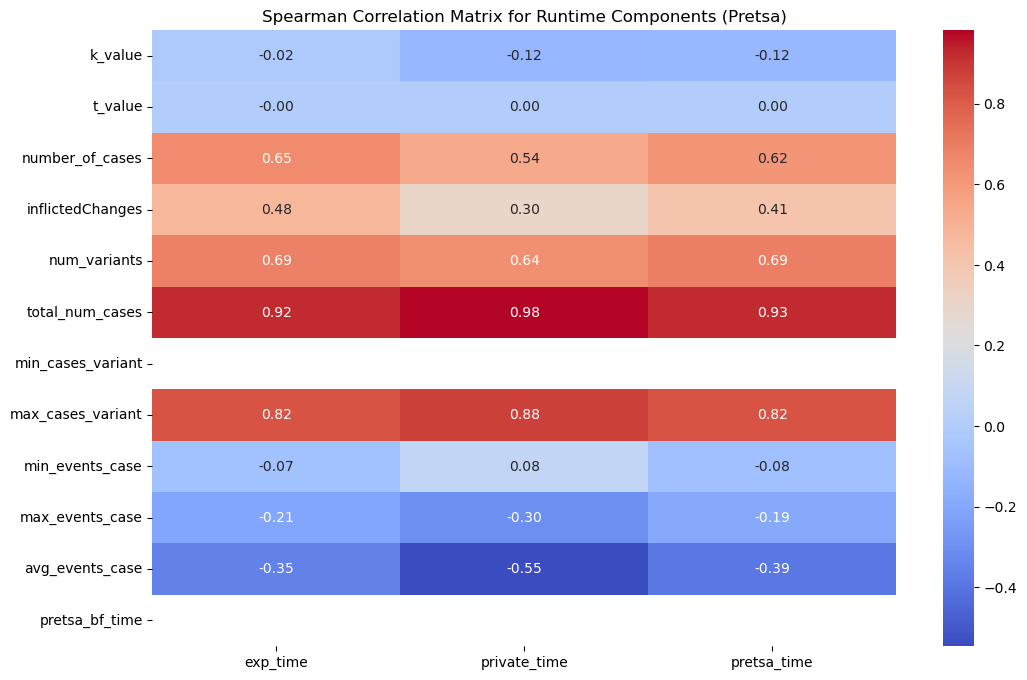

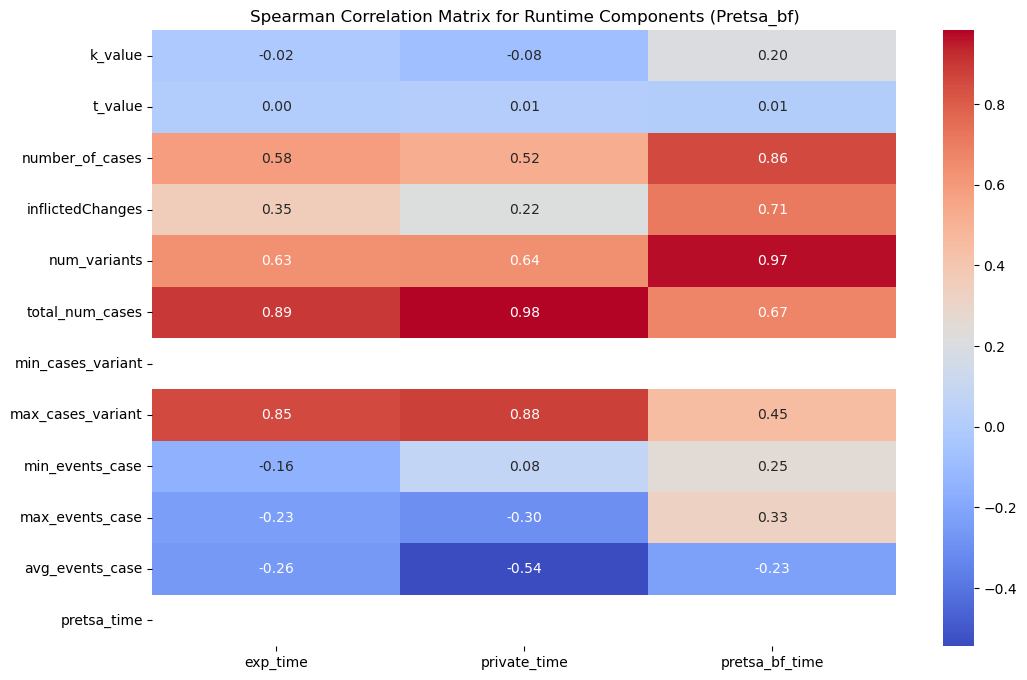

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns_pretsa = pretsa_df.select_dtypes(include=np.number).columns
numeric_columns_pretsa_bf = pretsa_bf_df.select_dtypes(include=np.number).columns


spearman_correlation_pretsa_numeric = pretsa_df[numeric_columns_pretsa].corr(method='spearman')
spearman_correlation_pretsa_bf_numeric = pretsa_bf_df[numeric_columns_pretsa_bf].corr(method='spearman')


spearman_runtime_correlations_pretsa_numeric = spearman_correlation_pretsa_numeric[['exp_time', 'private_time', 'pretsa_time']].drop(['exp_time', 'private_time', 'pretsa_time', 'total_time'], axis=0)
spearman_runtime_correlations_pretsa_bf_numeric = spearman_correlation_pretsa_bf_numeric[['exp_time', 'private_time', 'pretsa_bf_time']].drop(['exp_time', 'private_time', 'pretsa_bf_time', 'total_time'], axis=0)


plt.figure(figsize=(12, 8))
sns.heatmap(spearman_runtime_correlations_pretsa_numeric, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Spearman Correlation Matrix for Runtime Components (Pretsa)")
plt.show()


plt.figure(figsize=(12, 8))
sns.heatmap(spearman_runtime_correlations_pretsa_bf_numeric, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Spearman Correlation Matrix for Runtime Components (Pretsa_bf)")
plt.show()


In [31]:
pretsa_bf_df.groupby(['k_value', 't_value']).first()

eventlog  algorithm  number_of_cases  inflictedChanges  \
k_value t_value                                                           
4       1        bpic2011  pretsa_bf               30              38.0   
        2        bpic2011  pretsa_bf               30              38.0   
        3        bpic2011  pretsa_bf               30              38.0   
        4        bpic2011  pretsa_bf               30              38.0   
        5        bpic2011  pretsa_bf               30              38.0   
8       1        bpic2011  pretsa_bf               57             184.0   
        2        bpic2011  pretsa_bf               57             184.0   
        3        bpic2011  pretsa_bf               57             184.0   
        4        bpic2011  pretsa_bf               57             184.0   
        5        bpic2011  pretsa_bf               57             184.0   
16      1        bpic2011  pretsa_bf               87             251.0   
        2        bpic2011  pretsa_bf               87             251.0   
        3        bpic2011  pretsa_bf               87             251.0   
        4        bpic2011  pretsa_bf               87             251.0   
        5        bpic2011  pretsa_bf               87             251.0   
32      1        bpic2011  pretsa_bf              120             362.0   
        2        bpic2011  pretsa_bf              120             362.0   
        3        bpic2011  pretsa_bf              120             362.0   
        4        bpic2011  pretsa_bf              120             362.0   
        5        bpic2011  pretsa_bf              120             362.0   
64      1        bpic2011  pretsa_bf              148             510.0   
        2        bpic2011  pretsa_bf              148             510.0   
        3        bpic2011  pretsa_bf              148             510.0   
        4        bpic2011  pretsa_bf              148             510.0   
        5        bpic2011  pretsa_bf              148             510.0   

                 total_time  num_variants  total_num_cases  min_cases_variant  \
k_value t_value                                                                 
4       1          0.504984          38.0            200.0                2.0   
        2          0.514825          38.0            200.0                2.0   
        3          0.989988          38.0            200.0                2.0   
        4          1.120257          38.0            200.0                2.0   
        5          0.553890          38.0            200.0                2.0   
8       1          1.331454          38.0            200.0                2.0   
        2          1.060752          38.0            200.0                2.0   
        3          1.345261          38.0            200.0                2.0   
        4          2.186024          38.0            200.0                2.0   
        5          1.067577          38.0            200.0                2.0   
16      1          1.467021          38.0            200.0                2.0   
        2          1.548175          38.0            200.0                2.0   
        3          1.489927          38.0            200.0                2.0   
        4          1.561555          38.0            200.0                2.0   
        5          1.493057          38.0            200.0                2.0   
32      1          1.900297          38.0            200.0                2.0   
        2          1.805461          38.0            200.0                2.0   
        3          1.813667          38.0            200.0                2.0   
        4          2.637678          38.0            200.0                2.0   
        5          3.590832          38.0            200.0                2.0   
64      1          2.256050          38.0            200.0                2.0   
        2          3.085353          38.0            200.0                2.0   
        3          3.328068          38.0      

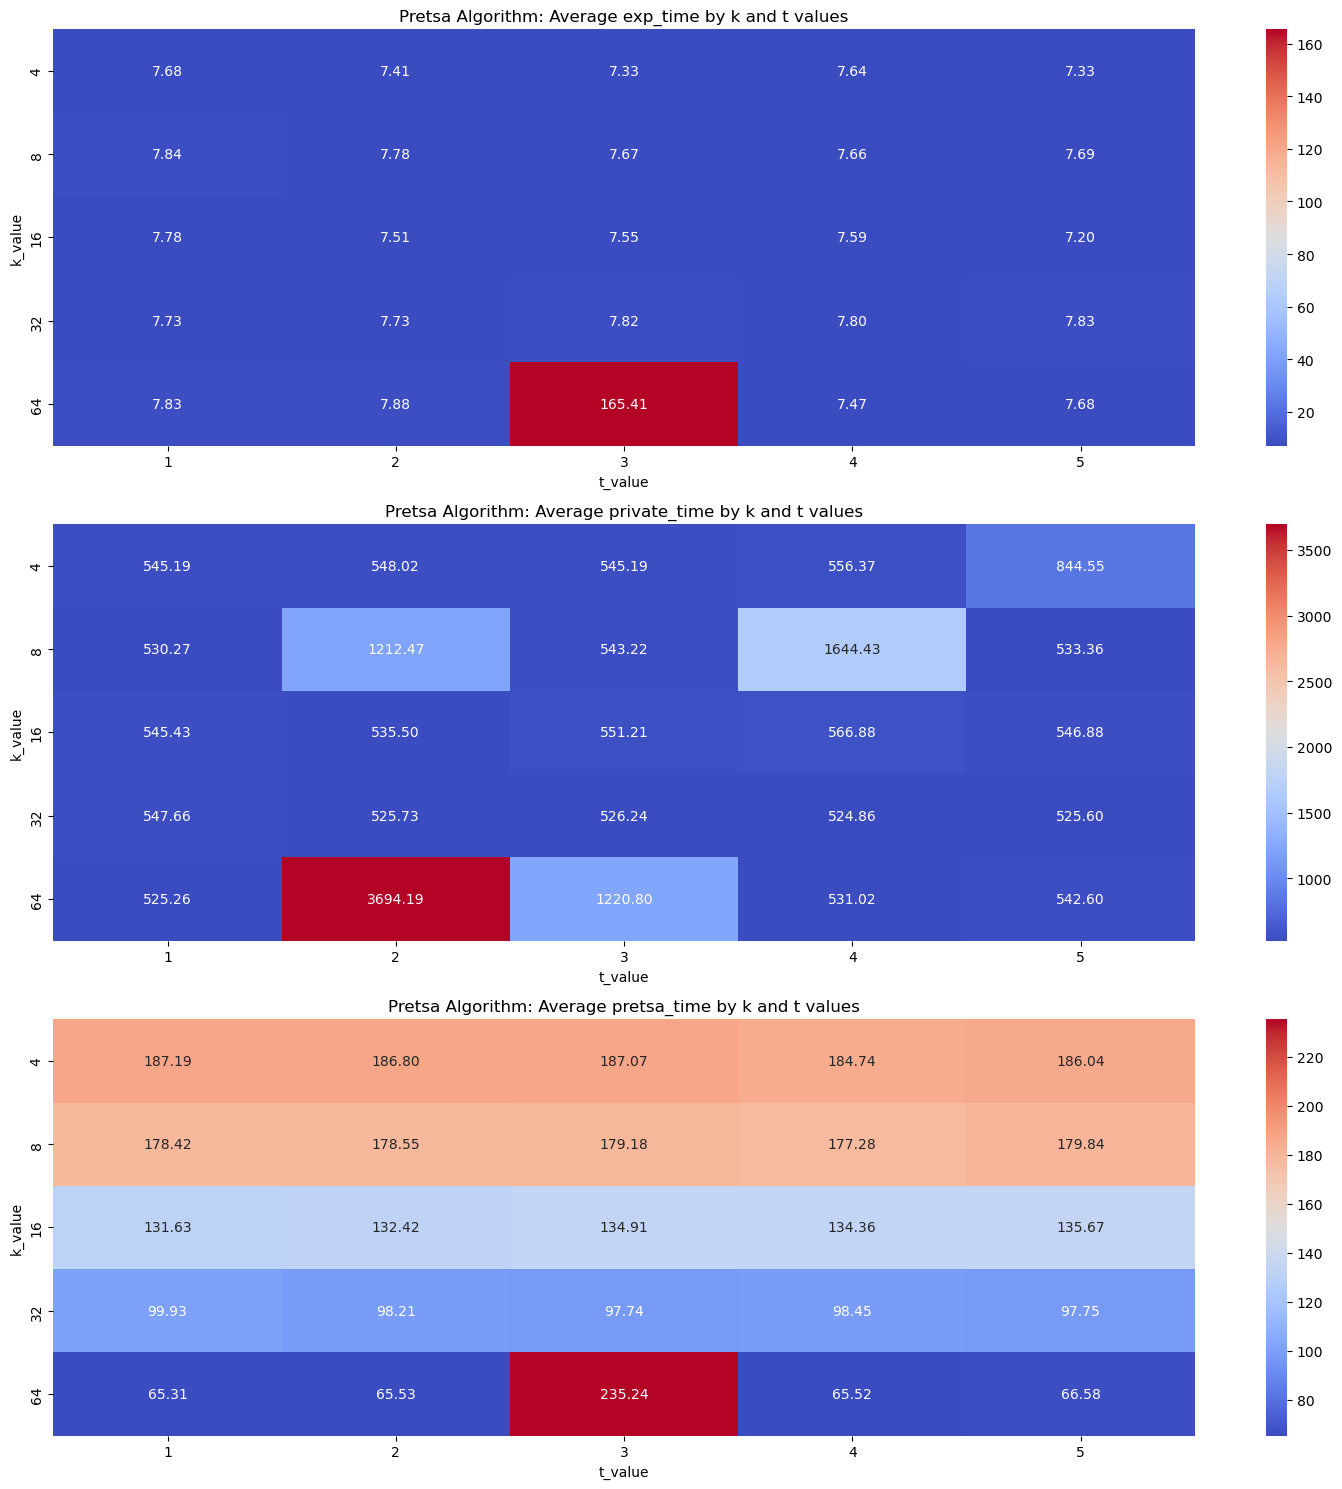

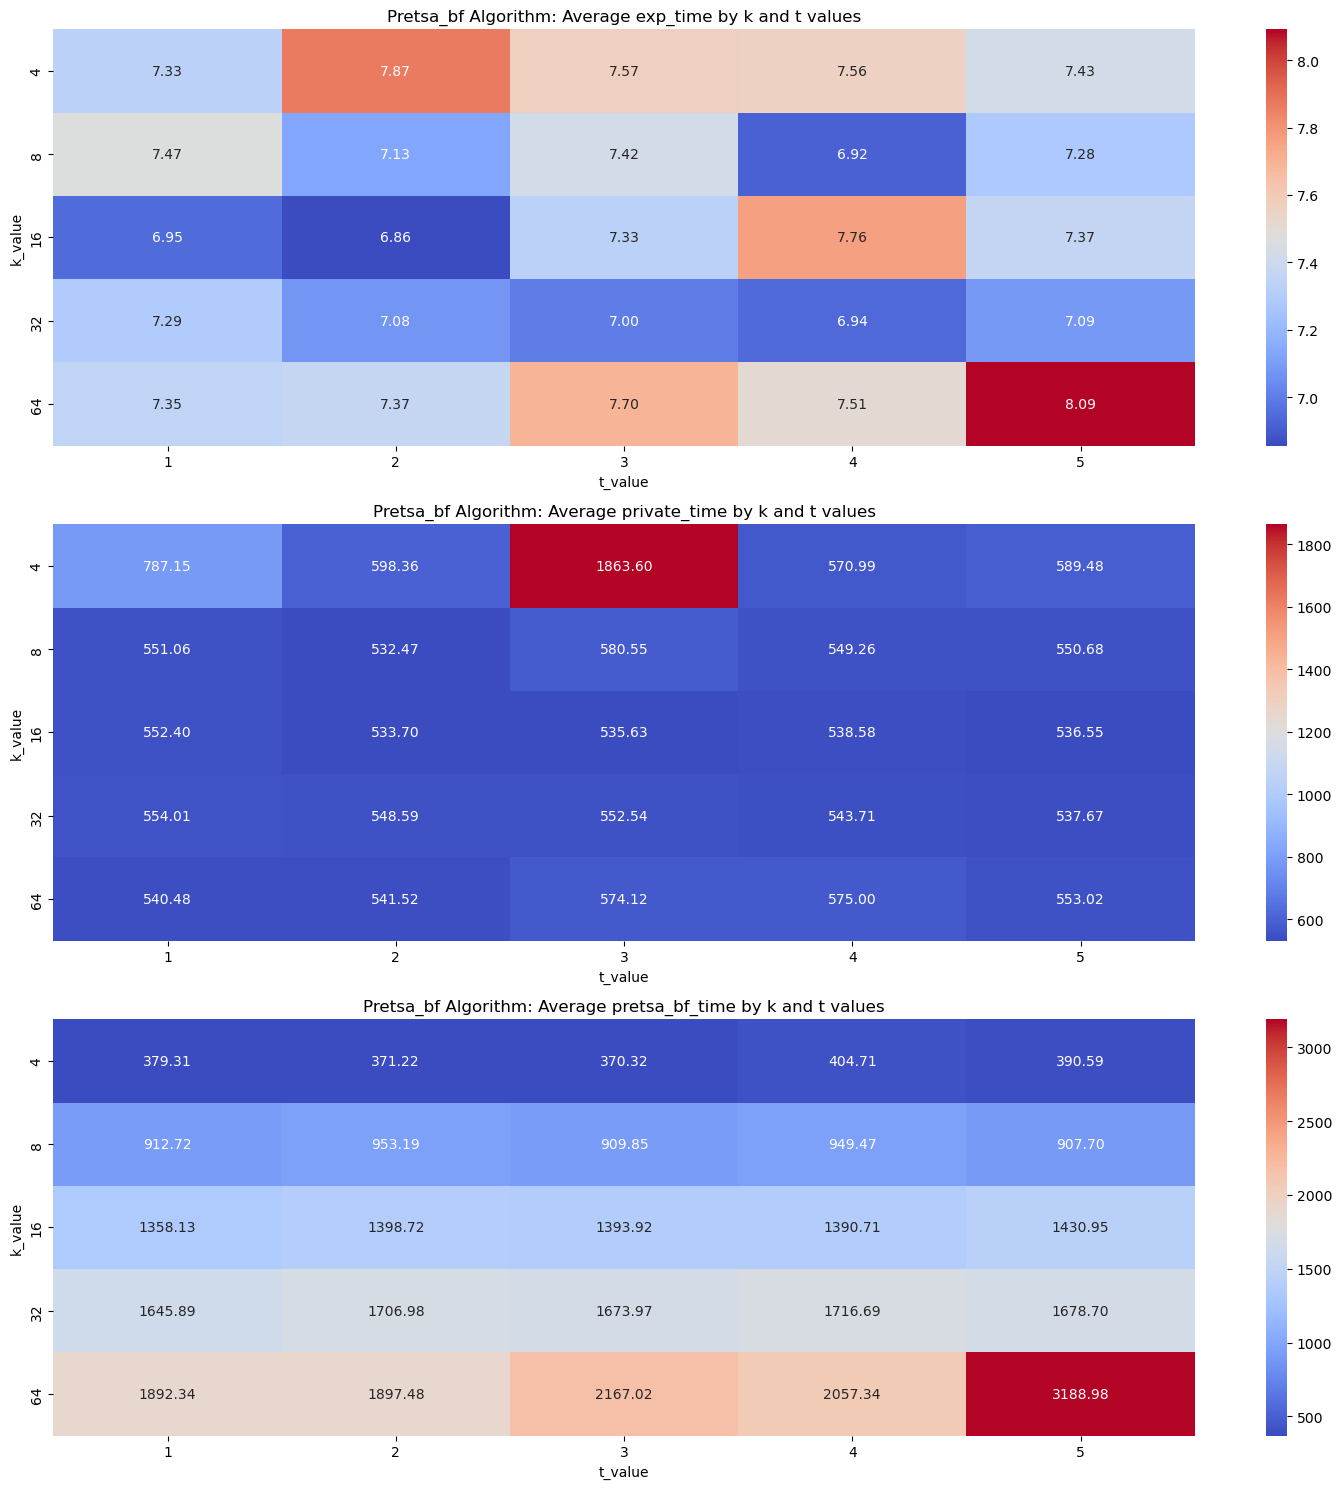

In [32]:
numeric_columns_pretsa = pretsa_df.select_dtypes(include=np.number).columns
numeric_columns_pretsa_bf = pretsa_bf_df.select_dtypes(include=np.number).columns


grouped_pretsa_corrected_numeric = pretsa_df[numeric_columns_pretsa].groupby(['k_value', 't_value']).mean().sort_index()
grouped_pretsa_bf_corrected_numeric = pretsa_bf_df[numeric_columns_pretsa_bf].groupby(['k_value', 't_value']).mean().sort_index()


fig, axes = plt.subplots(3, 1, figsize=(15, 15))


sns.heatmap(grouped_pretsa_corrected_numeric['exp_time'].unstack(), ax=axes[0], annot=True, fmt=".2f", cmap='coolwarm')
axes[0].set_title('Pretsa Algorithm: Average exp_time by k and t values')


sns.heatmap(grouped_pretsa_corrected_numeric['private_time'].unstack(), ax=axes[1], annot=True, fmt=".2f", cmap='coolwarm')
axes[1].set_title('Pretsa Algorithm: Average private_time by k and t values')


sns.heatmap(grouped_pretsa_corrected_numeric['pretsa_time'].unstack(), ax=axes[2], annot=True, fmt=".2f", cmap='coolwarm')
axes[2].set_title('Pretsa Algorithm: Average pretsa_time by k and t values')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(3, 1, figsize=(15, 15))


sns.heatmap(grouped_pretsa_bf_corrected_numeric['exp_time'].unstack(), ax=axes[0], annot=True, fmt=".2f", cmap='coolwarm')
axes[0].set_title('Pretsa_bf Algorithm: Average exp_time by k and t values')


sns.heatmap(grouped_pretsa_bf_corrected_numeric['private_time'].unstack(), ax=axes[1], annot=True, fmt=".2f", cmap='coolwarm')
axes[1].set_title('Pretsa_bf Algorithm: Average private_time by k and t values')


sns.heatmap(grouped_pretsa_bf_corrected_numeric['pretsa_bf_time'].unstack(), ax=axes[2], annot=True, fmt=".2f", cmap='coolwarm')
axes[2].set_title('Pretsa_bf Algorithm: Average pretsa_bf_time by k and t values')

plt.tight_layout()
plt.show()



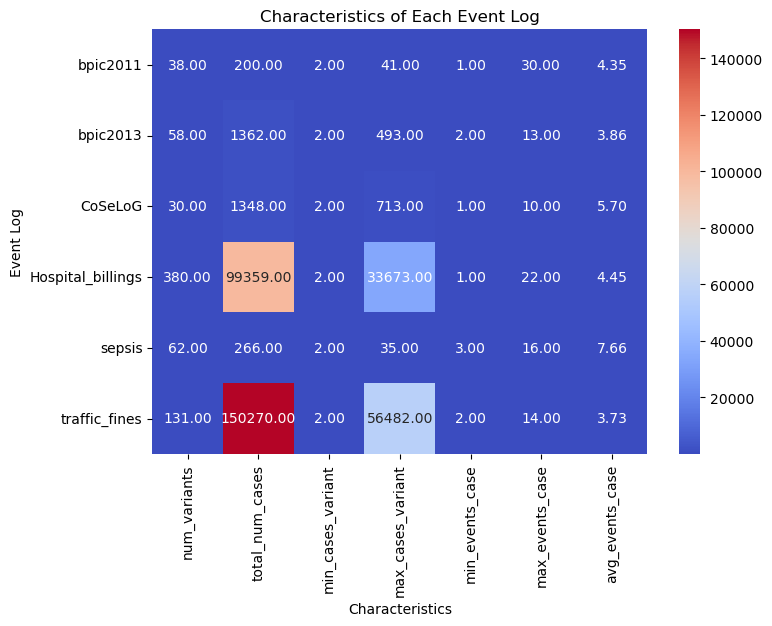

In [33]:
import pandas as pd

event_log_characteristics_df = pd.DataFrame.from_dict(event_log_characteristics, orient='index')

plt.figure(figsize=(8, 6))  
sns.heatmap(event_log_characteristics_df, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Characteristics of Each Event Log")
plt.ylabel("Event Log")
plt.xlabel("Characteristics")
plt.tight_layout()  
plt.show()


In [34]:

alpha, beta, gamma = 1/3, 1/3, 1/3  

unified_insights_df['interaction_score'] = (
    alpha * unified_insights_df['max_cases_variant'] +
    beta * unified_insights_df['num_variants'] +
    gamma * unified_insights_df['total_num_cases']
)



In [88]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def train_regression_models(unified_df, train_logs):
    features = ['max_cases_variant', 'num_variants', 'total_num_cases', 'k_value', 't_value']
    target_components = {
        'pretsa': ['pretsa_time', 'private_time'],
        'pretsa_bf': ['pretsa_bf_time', 'private_time']
    }

    coefficients = {}

    for algorithm, components in target_components.items():
        for component in components:

            data_df = unified_df[(unified_df['algorithm'] == algorithm) & (unified_df['eventlog'].isin(train_logs))]


            data_df = data_df.dropna(subset=[component])
            X_train = data_df[features]
            y_train = data_df[component]


            model = LinearRegression().fit(X_train, y_train)
            coefficients[f"{algorithm}_{component}"] = model.coef_

    return coefficients

def estimate_runtime(log_features, coefficients, algorithm):
    estimated_runtimes = {}
    for component in ['time', 'private_time']:
        key = f"{algorithm}_{component}"
        if key in coefficients:
            estimated_runtimes[component] = np.dot(coefficients[key], log_features)

    return estimated_runtimes

def train_and_estimate_runtimes(train_logs, estimate_logs, unified_df):

    # unified_df['k_value'] = unified_df['k'].apply(lambda x: int(x))
    # unified_df['t_value'] = unified_df['t'].apply(lambda x: int(x))


    coefficients = train_regression_models(unified_df, train_logs)


    comparison_results = {}
    for log in estimate_logs:
        log_data = unified_df[unified_df['eventlog'] == log].iloc[0]
        log_features = [log_data[feature] for feature in ['max_cases_variant', 'num_variants', 'total_num_cases', 'k_value', 't_value']]
        algorithm = log_data['algorithm']

        estimated_runtimes = estimate_runtime(log_features, coefficients, algorithm)
        actual_runtimes = unified_df[unified_df['eventlog'] == log][['pretsa_time', 'private_time', 'pretsa_bf_time']].mean()
        
        comparison_results[log] = {
            'Estimated': estimated_runtimes,
            'Actual': actual_runtimes.to_dict()
        }

    return comparison_results


train_logs = ['Hospital_billings', 'CoSeLoG', 'traffic_fines']
estimate_logs = ['sepsis']
results = train_and_estimate_runtimes(train_logs, estimate_logs, unified_insights_df)


for log, data in results.items():
    print(f"Results for {log}:\nEstimated: {data['Estimated']}\nActual: {data['Actual']}\n")


Results for sepsis:
Estimated: {'private_time': 51.606403740100404}
Actual: {'pretsa_time': 0.059179067611694336, 'private_time': 0.04339083194732666, 'pretsa_bf_time': 12.001650819778442}



In [91]:
for log_name, characteristics in event_log_characteristics.items():
    print(f"Event Log: {log_name}")
    for characteristic, value in characteristics.items():
        print(f"  {characteristic}: {value}")
    print("\n")

Event Log: bpic2013
  num_variants: 58
  total_num_cases: 1362
  min_cases_variant: 2
  max_cases_variant: 493
  min_events_case: 2
  max_events_case: 13
  avg_events_case: 3.8649045521292216


Event Log: CoSeLoG
  num_variants: 30
  total_num_cases: 1348
  min_cases_variant: 2
  max_cases_variant: 713
  min_events_case: 1
  max_events_case: 10
  avg_events_case: 5.704747774480712


Event Log: Hospital_billings
  num_variants: 380
  total_num_cases: 99359
  min_cases_variant: 2
  max_cases_variant: 33673
  min_events_case: 1
  max_events_case: 22
  avg_events_case: 4.45244014130577


Event Log: sepsis
  num_variants: 62
  total_num_cases: 266
  min_cases_variant: 2
  max_cases_variant: 35
  min_events_case: 3
  max_events_case: 16
  avg_events_case: 7.661654135338346


Event Log: traffic_fines
  num_variants: 131
  total_num_cases: 150270
  min_cases_variant: 2
  max_cases_variant: 56482
  min_events_case: 2
  max_events_case: 14
  avg_events_case: 3.730292140813203




# Pretsa vs BF Pretsa vs Pretsa Star

In [44]:
file_path_run_insights = "algo_output_comparision.pickle"
with open(file_path_run_insights, 'rb') as file:
    run_insights = pickle.load(file)

run_insights_df = pd.DataFrame.from_dict(run_insights)
run_insights_df

cases  cases_nr  \
0    {258, 514, 390, 903, 392, 143, 528, 402, 914, ...        35   
1    {258, 903, 392, 528, 402, 786, 914, 407, 664, ...        30   
2                                                   -1        -1   
3    {258, 514, 390, 903, 392, 143, 528, 402, 914, ...        35   
4    {258, 903, 392, 528, 402, 786, 914, 407, 664, ...        30   
..                                                 ...       ...   
445  {V17289, S140553, S73707, N40865, S108869, A15...       674   
446                                                 -1        -1   
447  {V17289, N88918, N38309, S140553, S73707, N408...       846   
448  {V17289, S140553, S73707, N40865, S108869, A15...       674   
449                                                 -1        -1   

     inflictedChanges   sed     error   k  t         algorithm        dataset  
0                46.0    46  0.390681   4  1            pretsa       bpic2011  
1                38.0    38  0.490572   4  1  heuristic_pretsa       bpic2011  
2                -1.0    -1 -1.000000   4  1       pretsa_star       bpic2011  
3                46.0    46  0.422894   4  2            pretsa       bpic2011  
4                38.0    38  0.445974   4  2  heuristic_pretsa       bpic2011  
..                ...   ...       ...  .. ..               ...            ...  
445            1110.0  1016  0.023290  64  4  heuristic_pretsa  traffic_fines  
446              -1.0    -1 -1.000000  64  4       pretsa_star  traffic_fines  
447            1118.0  1352  0.022631  64  5            pretsa  traffic_fines  
448            1110.0  1016  0.023188  64  5  heuristic_pretsa  traffic_fines  
449              -1.0    -1 -1.000000  64  5       pretsa_star  traffic_fines  

[450 rows x 9 columns]

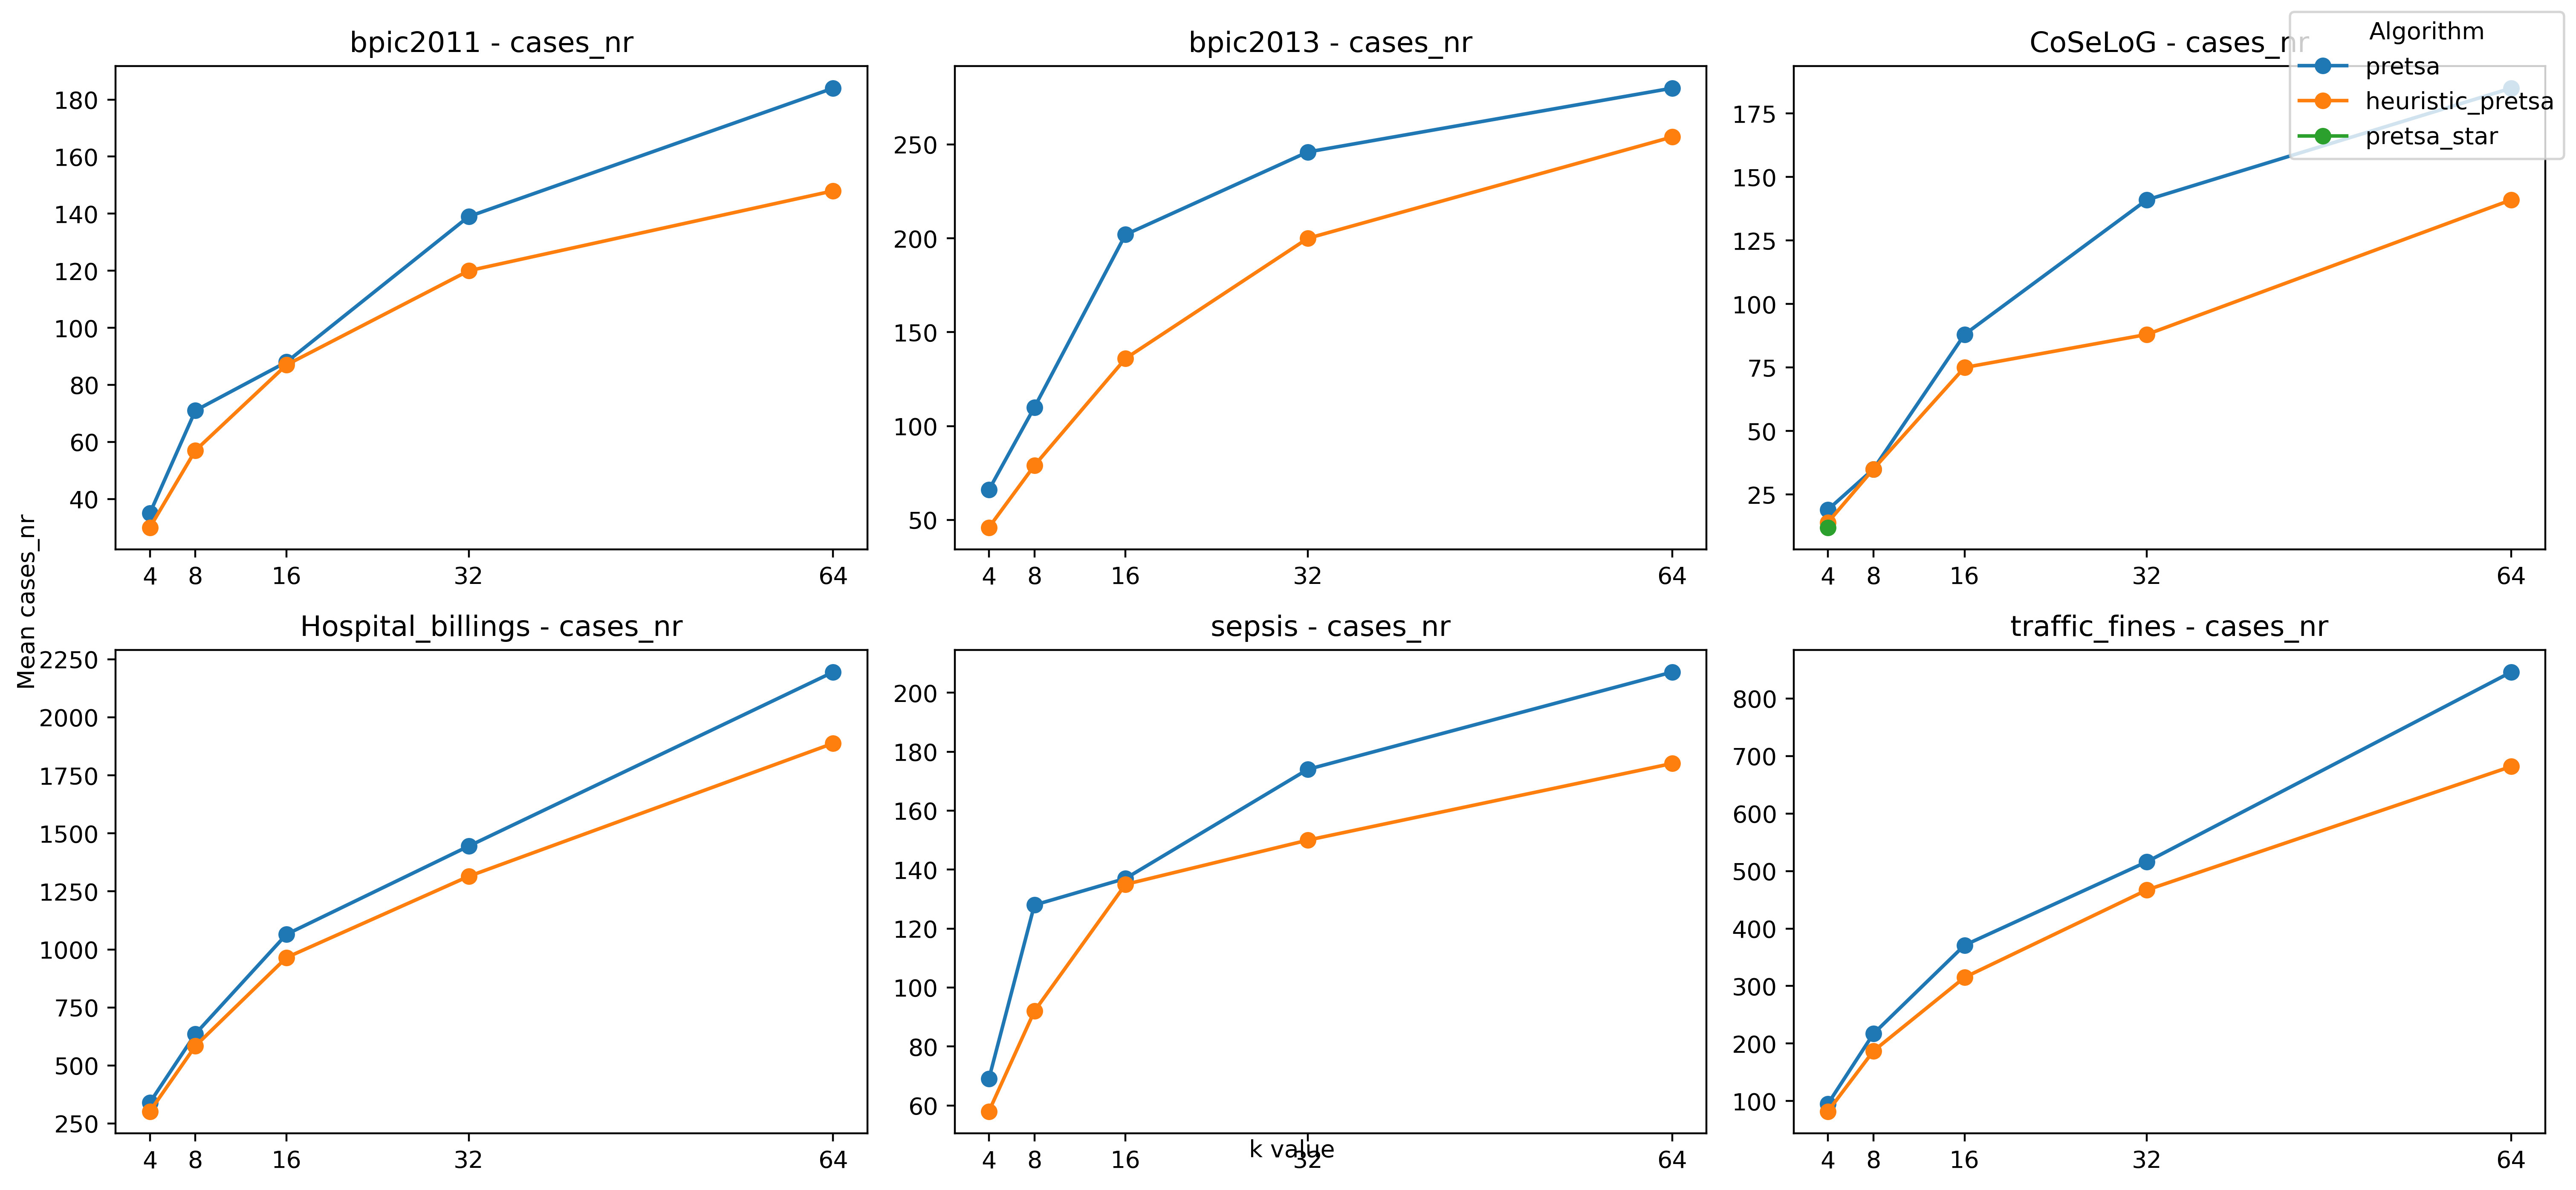

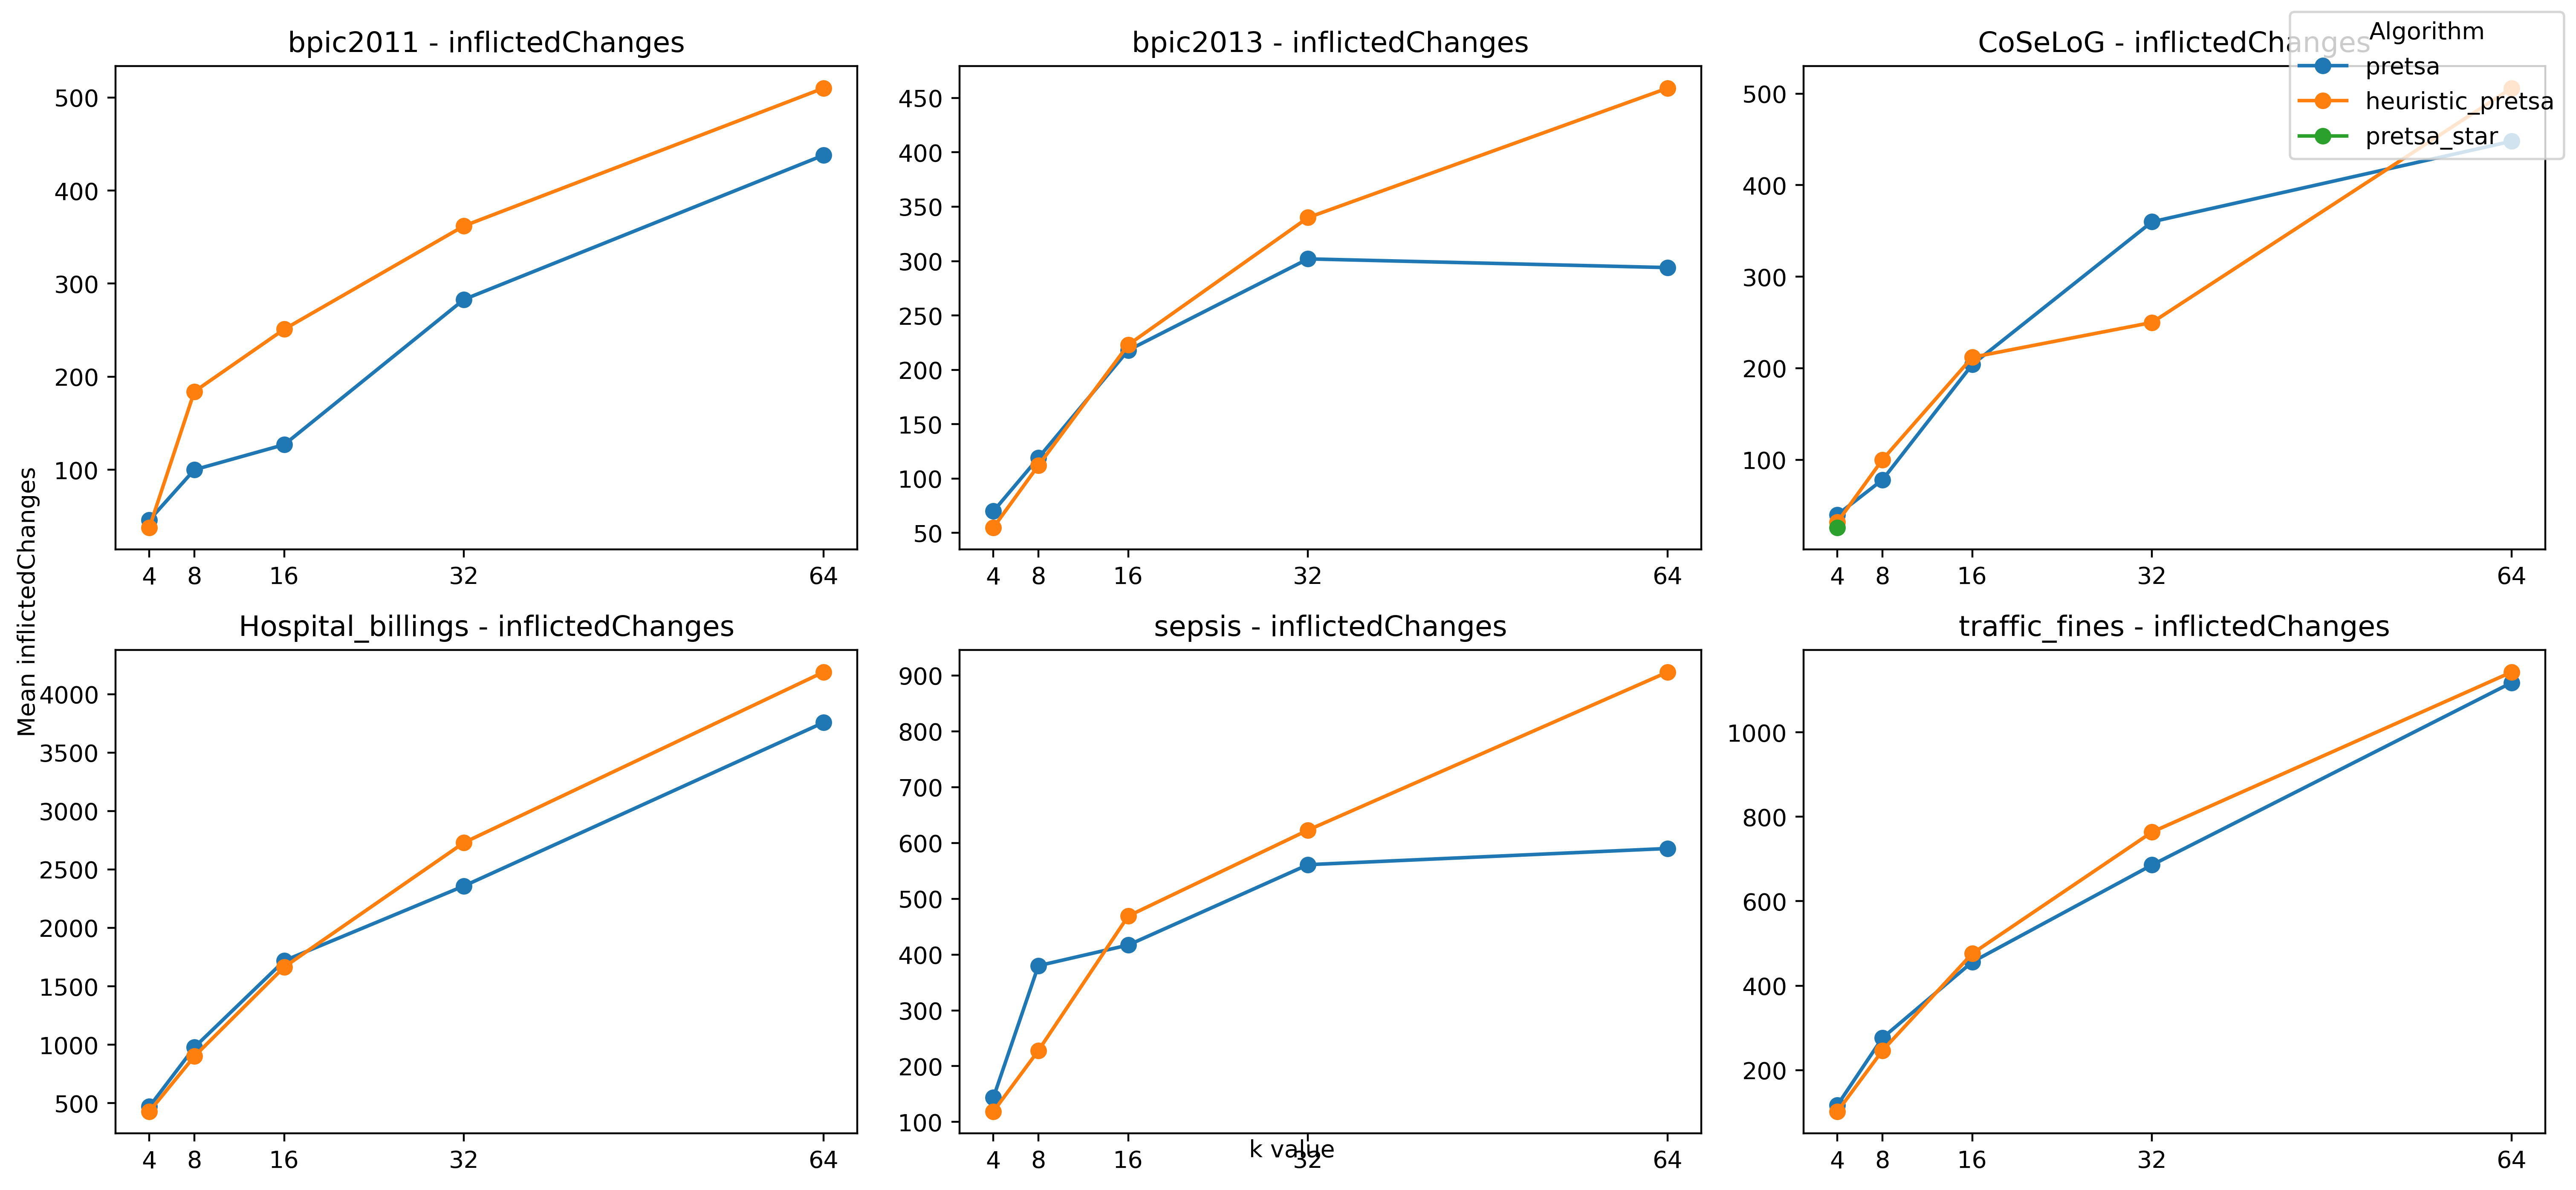

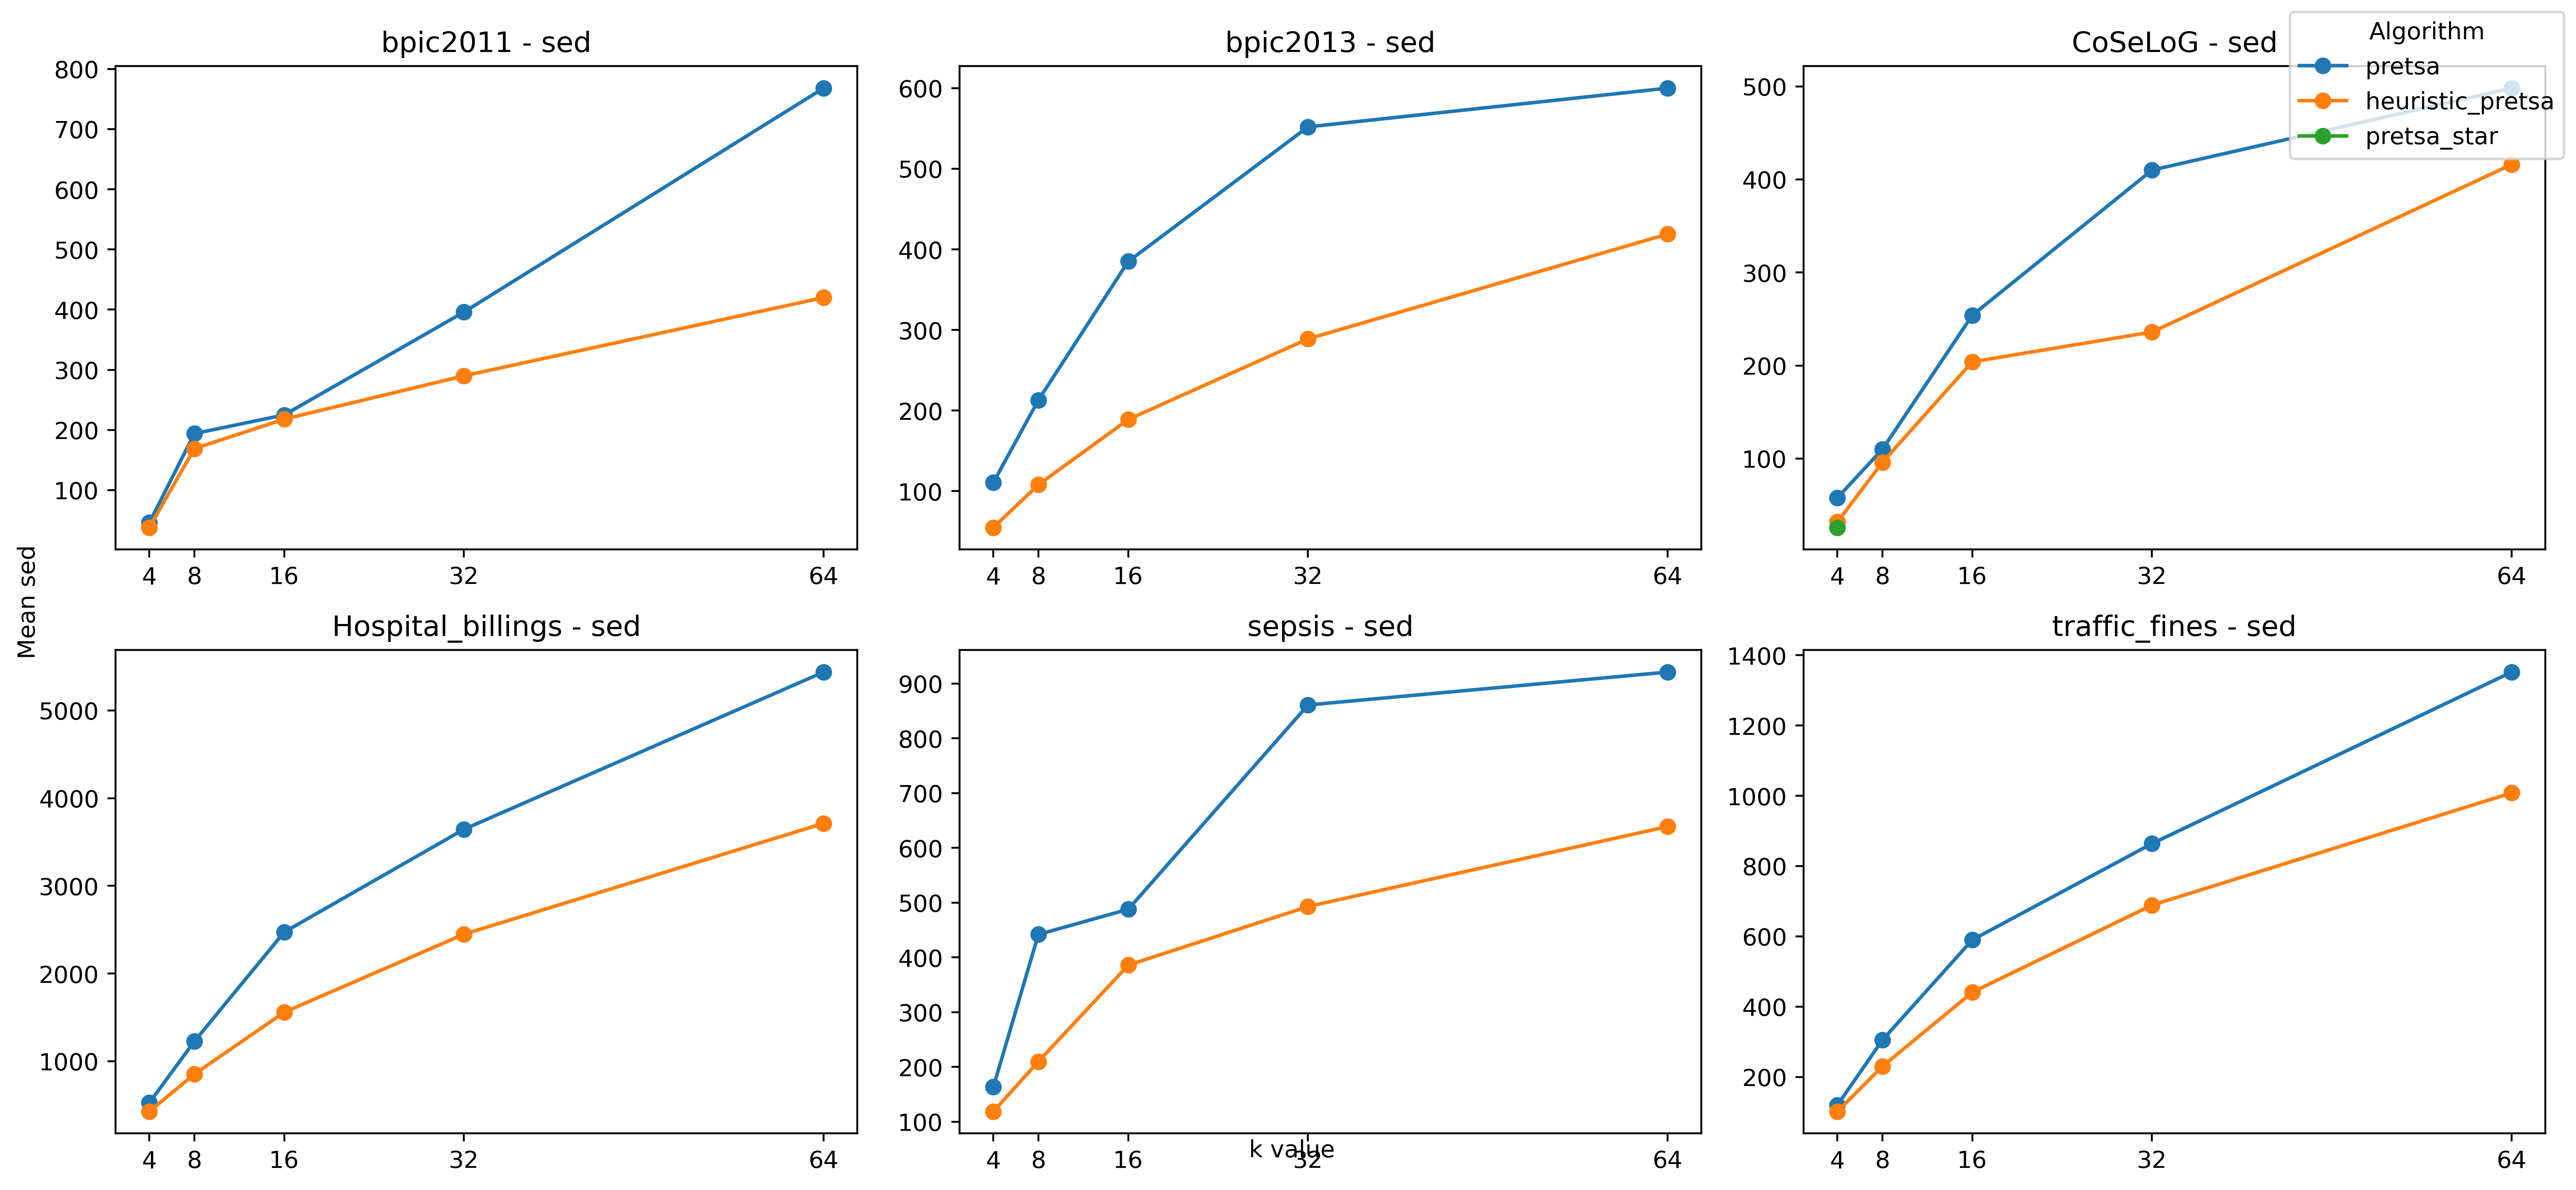

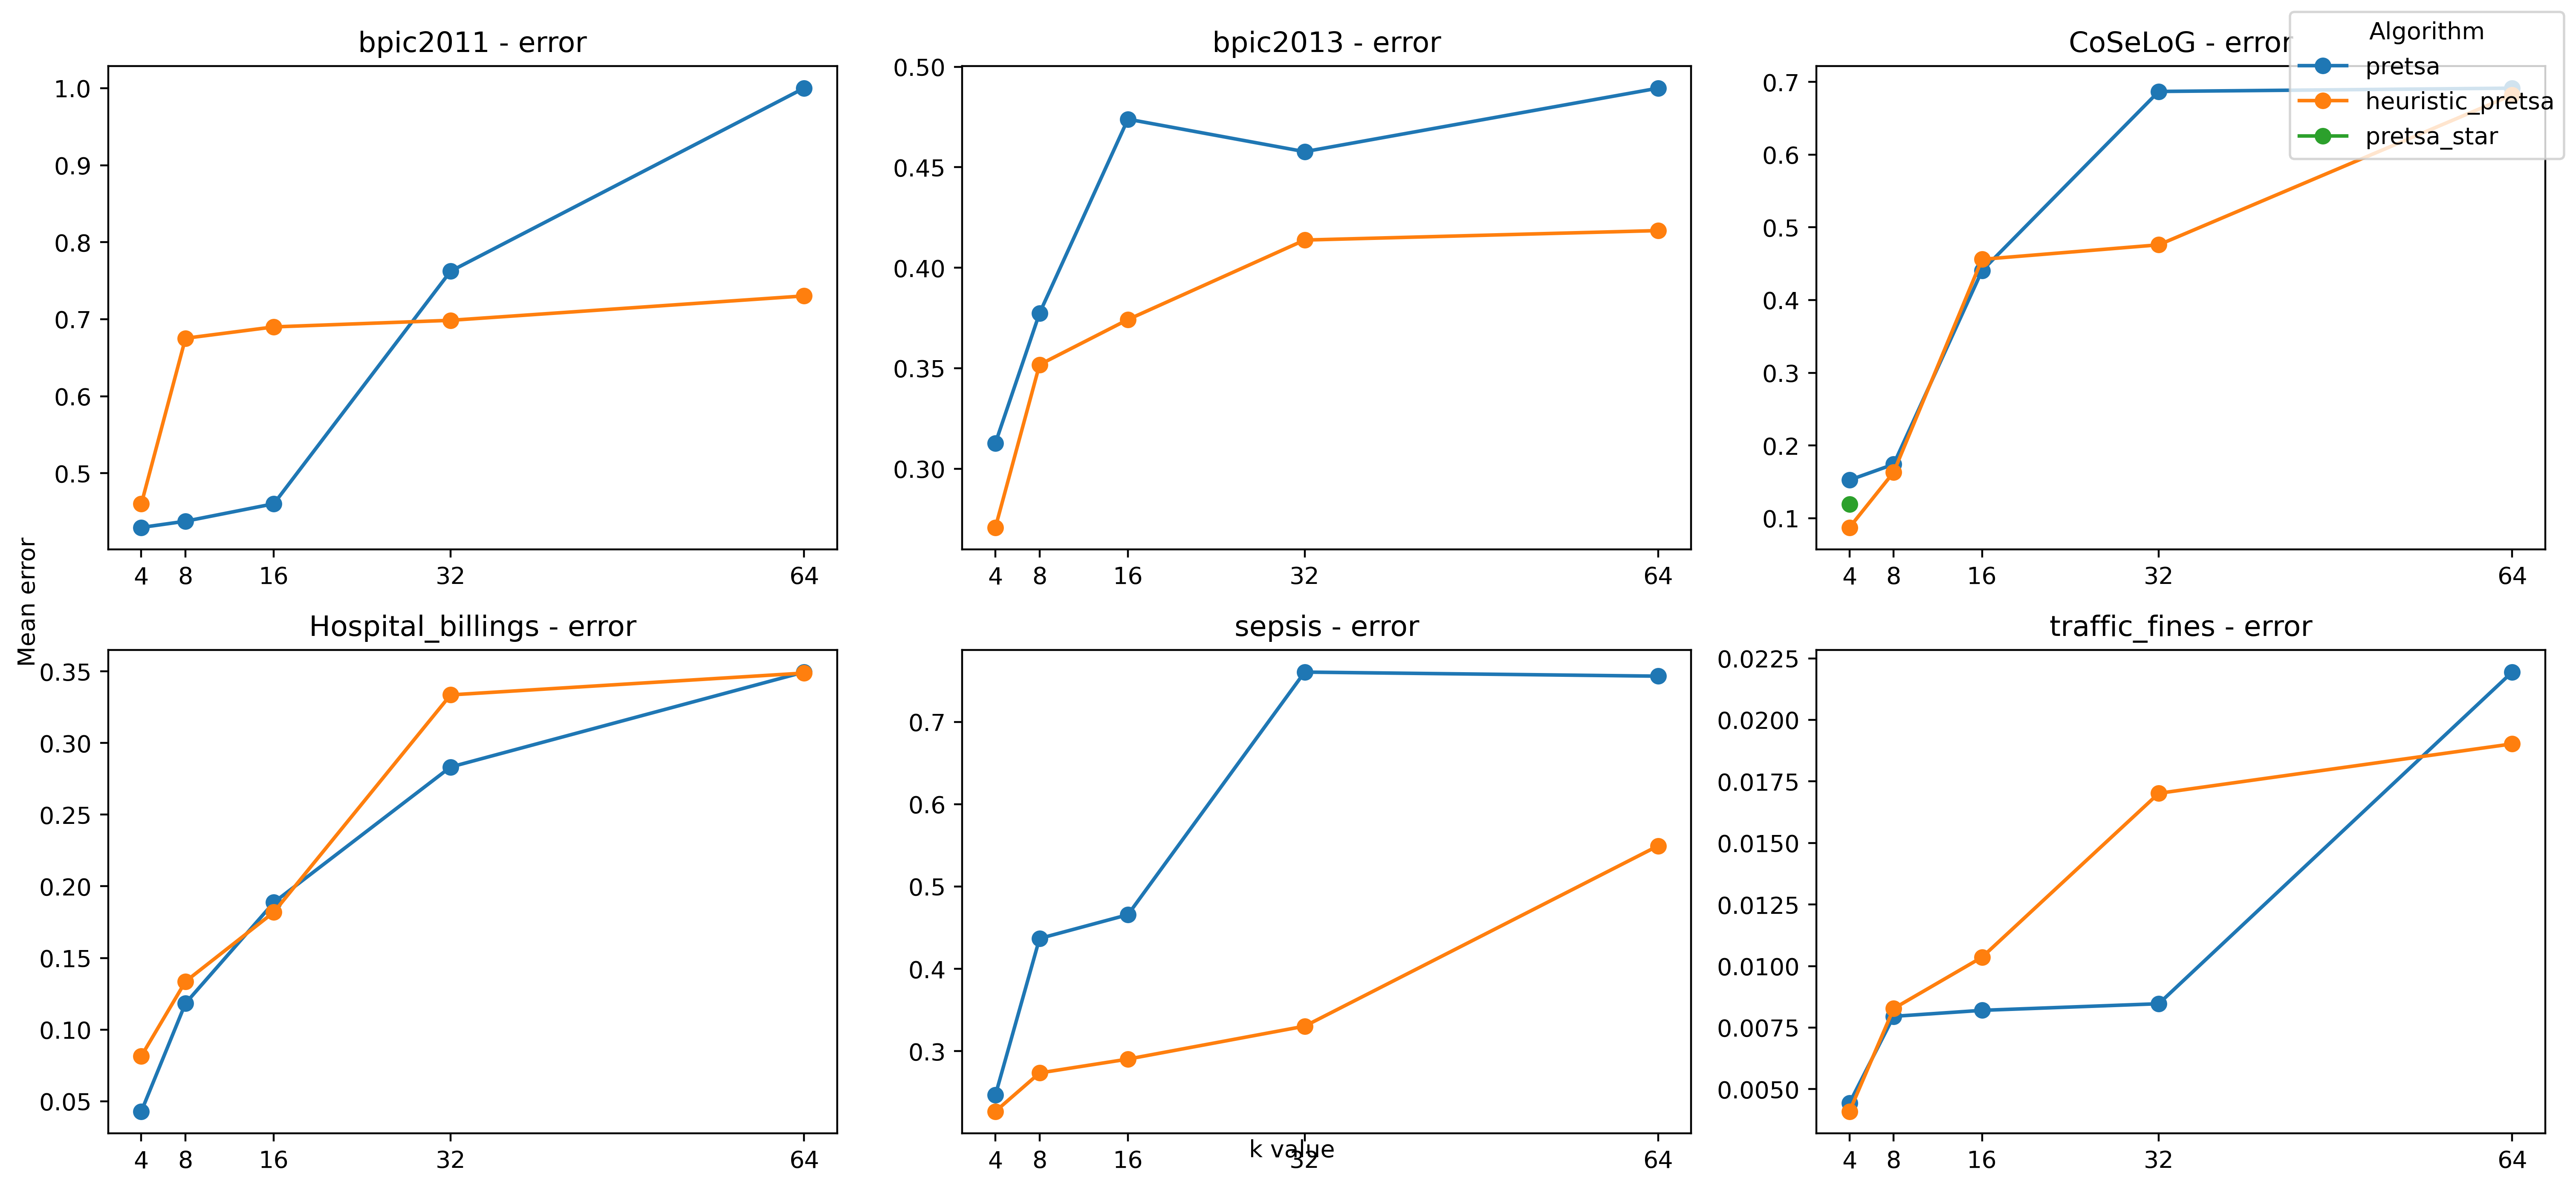

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


unique_datasets = run_insights_df['dataset'].unique()
unique_algorithms = run_insights_df['algorithm'].unique()


def plot_data(characteristic, datasets, algorithms, df):

    k_values_specified = [4, 8, 16, 32, 64]


    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7), dpi=400)

    for i, dataset in enumerate(datasets):
        ax = axes[i // 3, i % 3] 
        df_dataset = df[df['dataset'] == dataset]

        for algo in algorithms:
            df_algo = df_dataset[df_dataset['algorithm'] == algo]
            mean_values = df_algo.groupby('k')[characteristic].mean().reindex(k_values_specified)


            k_values = mean_values.index.to_numpy()
            char_values = mean_values.values

            ax.plot(k_values, char_values, label=algo, marker='o')  

        ax.set_title(f'{dataset} - {characteristic}')
        ax.set_xticks(k_values_specified)  


    fig.text(0.5, 0.04, 'k value', ha='center', va='center')
    fig.text(0.006, 0.5, f'Mean {characteristic}', ha='center', va='center', rotation='vertical')

    handles, labels = axes[-1, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', title='Algorithm')

    plt.tight_layout()
    return fig

df_cleaned = run_insights_df[(run_insights_df['cases_nr'] != -1) &
                             (run_insights_df['inflictedChanges'] != -1) &
                             (run_insights_df['sed'] != -1) &
                             (run_insights_df['error'] != -1)]

plot_data('cases_nr', unique_datasets, unique_algorithms, df_cleaned)
plt.show()
plot_data('inflictedChanges', unique_datasets, unique_algorithms, df_cleaned)
plt.show()
plot_data('sed', unique_datasets, unique_algorithms, df_cleaned)
plt.show()
plot_data('error', unique_datasets, unique_algorithms, df_cleaned)
plt.show()

